In [73]:
import pickle, glob

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors

from matplotlib import rc
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.signal import savgol_filter
from scipy import fftpack
from scipy import stats
from scipy.stats import multivariate_normal, norm
from scipy.ndimage.filters import gaussian_filter1d

import statsmodels.api as sm

from statsmodels.nonparametric.kernel_regression import KernelReg

from ast import literal_eval
from mpl_toolkits.axisartist.axislines import AxesZero
from matplotlib.ticker import StrMethodFormatter, NullFormatter, ScalarFormatter
from shapely.geometry import Point
from matplotlib.transforms import ScaledTranslation

import matplotlib as mpl

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams["font.family"]         = "Avenir"
#mpl.rcParams['pdf.fonttype'] = 42

path_to_images  = r'/Users/Guille/Desktop/caiso_power/images/'
path_to_aux     = r'/Users/Guille/Desktop/caiso_power/data/auxiliary/'
path_to_data    = r'/Users/Guille/Desktop/caiso_power/data/'
path_to_maps    = r'/Users/Guille/Desktop/caiso_power/data/maps/'
path_to_prc     = r'/Users/Guille/Desktop/caiso_power/data/processed/'


path_to_results = r'/Users/Guille/Desktop/caiso_power/results/journal_paper_w_sigma/'
path_to_results = r'/Users/Guille/Desktop/caiso_power/results/journal_paper_w_sigma_n_lambda/'
#path_to_mdls    = r'/Users/Guille/Desktop/caiso_power/models/journal_paper_w_sigma_n_lambda-Cal/'
path_to_mdls    = r'/Users/Guille/Desktop/caiso_power/models/journal_paper_w_sigma_n_lambda-Cal-2/'
#path_to_mdls    = r'/Users/Guille/Desktop/caiso_power/models/journal_paper_w_sigma_n_lambda-NoCal/'


# Get California unlities and remove the ones that are not CAISO
_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
_US    = gpd.read_file(path_to_maps + r"US/tl_2022_us_state.shp")
_CAISO = gpd.read_file(path_to_maps + r"CAISO/Balancing_Authority_Areas_in_CA.shp")
_CAISO = _CAISO.iloc[[1, 7]].to_crs("EPSG:4326")
W_ref_ = pickle.load(open(path_to_aux + r'ref_grid_0.125_(-125,-112)_(32,43).pkl', 'rb'))

resources_  = ['load', 'solar', 'wind']
dl_methods_ = ['BLR', 'RVM', 'GPR']
sl_methods_ = ['lasso', 'OMP', 'elastic_net', 'group_lasso']

colors_1_ = ['#7d6674', '#006995', '#f48d64', '#09155a', '#e6cd94', '#0041a5']
colors_2_ = ['#126463', '#2CB7B5', '#CA8250']
colors_3_ = ['#1F390D', '#756A00', '#D8A581', '#92918B']

/var/folders/0c/ffx2kgyn7xq4krqrpsv67l3m0000gn/T/ipykernel_4196/3082306442.py:21: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


# Baseline Model Scores

In [23]:
def _dataframe(data_, index_, columns_, method, resource):
    df_             = pd.DataFrame(data_, index = index_, columns = columns_)
    df_['zone']     = df_.index
    df_['method']   = method
    df_['resource'] = resource
    df_             = df_.reset_index(drop = True)
    return df_

Persistence_ = np.array([[1432.425405, 0.191187], [1580.078333,  -6.230624], [299.133371, -0.699760]])
CAISO_       = np.array([[607.075561, 273.938328], [647.596172, 267.898981], [164.827576, 72.686353]])
Climatoloty_ = np.array([[1336.276707, 9.815701], [1541.191602, -4.939872], [289.481101, 1.025492]])
Persistence_ = _dataframe(Persistence_, index_ = ['NP15', 'SP15', 'ZP26'], columns_ = ['RMSE', 'MBE'], method = 'Presistence', resource = 'load')
CAISO_       = _dataframe(CAISO_, index_ = ['NP15', 'SP15', 'ZP26'], columns_ = ['RMSE', 'MBE'], method = 'CAISO', resource = 'load')
Climatoloty_ = _dataframe(Climatoloty_, index_ = ['NP15', 'SP15', 'ZP26'], columns_ = ['RMSE', 'MBE'], method = 'Climatology', resource = 'load')
ref_         = pd.concat([Persistence_, Climatoloty_, CAISO_], axis = 0).reset_index(drop = True)

Persistence_ = np.array([[244.096715, -1.377402], [933.148375, -10.316115], [269.491617, -2.408633]])
CAISO_       = np.array([[255.950023, -95.328823], [649.992549, -258.398304], [209.531956, -65.376801]])
Climatoloty_ = np.array([[216.941925, -3.550991], [789.308296, -14.495869], [218.326947, -5.045071]])
Persistence_ = _dataframe(Persistence_, index_ = ['NP15', 'SP15', 'ZP26'], columns_ = ['RMSE', 'MBE'], method = 'Presistence', resource = 'solar')
CAISO_       = _dataframe(CAISO_, index_ = ['NP15', 'SP15', 'ZP26'], columns_ = ['RMSE', 'MBE'], method = 'CAISO', resource = 'solar')
Climatoloty_ = _dataframe(Climatoloty_, index_ = ['NP15', 'SP15', 'ZP26'], columns_ = ['RMSE', 'MBE'], method = 'Climatology', resource = 'solar')
ref_         = pd.concat([ref_, Persistence_, Climatoloty_, CAISO_], axis = 0).reset_index(drop = True)

Persistence_ = np.array([[455.203618, -0.012404], [1170.880167, -4.723570]])
CAISO_       = np.array([[166.998352, -41.077674], [387.69634, -156.006200]])
Climatoloty_ = np.array([[354.895993, -1.108021], [946.000155, -12.270927]])
Persistence_ = _dataframe(Persistence_, index_ = ['NP15', 'SP15'], columns_ = ['RMSE', 'MBE'], method = 'Presistence', resource = 'wind')
CAISO_       = _dataframe(CAISO_, index_ = ['NP15', 'SP15'], columns_ = ['RMSE', 'MBE'], method = 'CAISO', resource = 'wind')
Climatoloty_ = _dataframe(Climatoloty_, index_ = ['NP15', 'SP15'], columns_ = ['RMSE', 'MBE'], method = 'Climatology', resource = 'wind')
ref_         = pd.concat([ref_, Persistence_, Climatoloty_, CAISO_], axis = 0).reset_index(drop = True)
print(ref_)

           RMSE         MBE  zone       method resource
0   1432.425405    0.191187  NP15  Presistence     load
1   1580.078333   -6.230624  SP15  Presistence     load
2    299.133371   -0.699760  ZP26  Presistence     load
3   1336.276707    9.815701  NP15  Climatology     load
4   1541.191602   -4.939872  SP15  Climatology     load
5    289.481101    1.025492  ZP26  Climatology     load
6    607.075561  273.938328  NP15        CAISO     load
7    647.596172  267.898981  SP15        CAISO     load
8    164.827576   72.686353  ZP26        CAISO     load
9    244.096715   -1.377402  NP15  Presistence    solar
10   933.148375  -10.316115  SP15  Presistence    solar
11   269.491617   -2.408633  ZP26  Presistence    solar
12   216.941925   -3.550991  NP15  Climatology    solar
13   789.308296  -14.495869  SP15  Climatology    solar
14   218.326947   -5.045071  ZP26  Climatology    solar
15   255.950023  -95.328823  NP15        CAISO    solar
16   649.992549 -258.398304  SP15        CAISO  

## Multiresource Nodal Forecast Baseline

['NP15' 'SP15' 'ZP26']


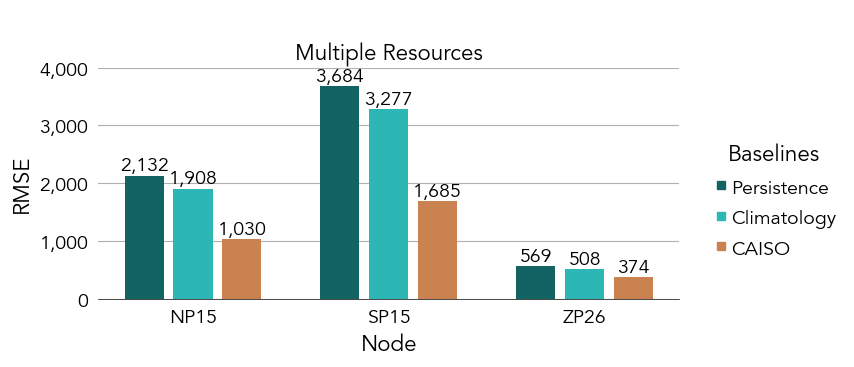

In [24]:
def _make_ref_node_plot(Scores_, zones_p_, legend_labels_, legend_title, colors_, 
                        ndecimals = 0,
                        score_key = 'value',
                        ref_      = [],
                        xlabel    = '',
                        ylabel    = '', 
                        title     = '', 
                        suptitle  = '', 
                        letter    = '',
                        y_lim     = 0,
                        save      = False, 
                        legend    = False, 
                        filename  = 'noname.pdf'):
    
    methods_ = Scores_['method'].unique()
    zones_   = Scores_['zone'].unique()
    print(zones_)
    
    x_     = np.linspace(0, .333*len(methods_), len(methods_))
    width  = 0.4
    offset = 2.
    
    fig = plt.figure(figsize = (len(zones_)*2.5, 3.))
    ax  = plt.subplot(111)
    
    plt.suptitle(suptitle, fontsize = 20, 
                           y        = 1.075)
    
    plt.title(title, fontsize = 16)

    ticks_ = []
    j      = 0

    for zone in zones_:
        i = 0
        for method in methods_:
            idx_  = (Scores_['method'] == method) & (Scores_['zone'] == zone) 
            value = Scores_.loc[idx_, score_key].sum()

            y = np.around(value, ndecimals)
            p = plt.bar(x_[i], y, width, color  = colors_[i], 
                                         zorder = 9, 
                                         align  = 'center')
            
            plt.bar_label(p, labels = [f'{x:,.0f}' for x in p.datavalues], size = 14)
           
            i += 1
        
        ticks_.append(x_.mean())
        x_ += offset
        j += 1
    # idx_  = Scores_['resource'] == resource
    # if y_lim == 0.:
    #     y_lim = Scores_.loc[idx_, score].max()
    # plt.ylim(-y_lim*0.005, y_lim*1.125)

    plt.xticks(ticks_[:len(zones_)], zones_p_, fontsize = 10)
    
    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        plt.legend(handles        = legend_, 
                   title          = legend_title, 
                   prop           = {'size': 14}, 
                   title_fontsize = 16,
                   ncol           = 1, 
                   columnspacing  = 0., 
                   handletextpad  = 0.,  
                   bbox_to_anchor = [1.3, .75],
                   frameon        = False)

    
    plt.grid(axis = 'y')

    ax.xaxis.set_tick_params(labelsize = 14, left = False)
    ax.yaxis.set_tick_params(labelsize = 14, left = False)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    
    plt.ylabel(ylabel, fontsize = 16)
    plt.xlabel(xlabel, fontsize = 16)
    
    ax.axhline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)

    plt.ylim(0,4000)
    
    if save:
        plt.savefig(path_to_images + filename, bbox_inches = 'tight',
                                               dpi         = 250)
    
    plt.show()
    
zones_p_   = ['PG&E', 'SDGE', 'SCE']
zones_   = ['NP15', 'SP15', 'ZP26']

_make_ref_node_plot(ref_, zones_, 
                    colors_        = colors_2_, 
                    ndecimals      = 0, 
                    score_key      = 'RMSE',
                    legend_labels_ = ['Persistence', 'Climatology', 'CAISO'], 
                    suptitle       = r' ', 
                    title          = r'Multiple Resources',
                    xlabel         = r'Node',
                    ylabel         = r'RMSE',
                    legend_title   = r'Baselines',
                    letter         = '',
                    y_lim          = 4000.,
                    save           = True, 
                    legend         = True, 
                    filename       = 'ref_node_RMSE.png')

## Aggregated Resource Forecast Baseline

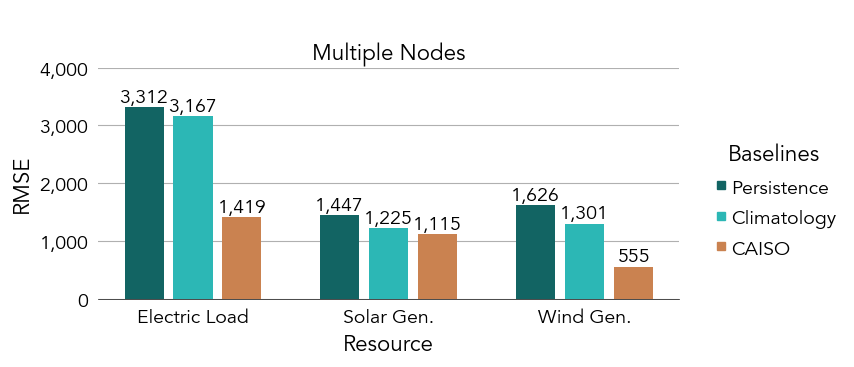

In [25]:
def _make_ref_agg_resources_plot(Scores_, zones_p_, legend_labels_, legend_title, colors_, 
                                 ndecimals = 0,
                                 score_key = 'value',
                                 xlabel    = '',
                                 ylabel    = '', 
                                 title     = '', 
                                 suptitle  = '', 
                                 letter    = '',
                                 y_lim     = 0,
                                 save      = False, 
                                 legend    = False, 
                                 filename  = 'noname.pdf'):

    methods_   = Scores_['method'].unique()
    zones_     = Scores_['zone'].unique()
    resources_ = Scores_['resource'].unique()

    x_     = np.linspace(0, .333*len(methods_), len(methods_))
    width  = 0.4
    offset = 2.
    
    fig = plt.figure(figsize = (len(zones_)*2.5, 3.))
    ax  = plt.subplot(111)
    
    plt.suptitle(suptitle, fontsize = 20, 
                           y        = 1.075)
    
    plt.title(title, fontsize = 16)

    ticks_ = []
    j      = 0

    for resource in resources_:
        i = 0
        for method in methods_:
            idx_ = (Scores_['method'] == method) & (Scores_['resource'] == resource) 

            y = np.around(Scores_.loc[idx_, score_key].sum(), ndecimals)
            p = plt.bar(x_[i], y, width, color  = colors_[i], 
                                         zorder = 9, 
                                         align  = 'center')
            plt.bar_label(p, labels=[f'{x:,.0f}' for x in p.datavalues], size = 14)
           
            i += 1
        
        ticks_.append(x_.mean())
        x_ += offset
        j += 1
    # idx_  = Scores_['resource'] == resource
    # if y_lim == 0.:
    #     y_lim = Scores_.loc[idx_, score].max()
    # plt.ylim(-y_lim*0.005, y_lim*1.125)

    plt.xticks(ticks_[:len(zones_p_)], zones_p_, fontsize = 10)
    
    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        plt.legend(handles        = legend_, 
                   title          = legend_title, 
                   prop           = {'size': 14}, 
                   title_fontsize = 16,
                   ncol           = 1, 
                   columnspacing  = 0., 
                   handletextpad  = 0.,  
                   bbox_to_anchor = [1.3, .75],
                   frameon        = False)

    
    plt.grid(axis = 'y')

    ax.xaxis.set_tick_params(labelsize = 14, left = False)
    ax.yaxis.set_tick_params(labelsize = 14, left = False)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    
    plt.ylabel(ylabel, fontsize = 16)
    plt.xlabel(xlabel, fontsize = 16)
    
    ax.axhline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)

    plt.ylim(0, 4000)
    
    if save:
        plt.savefig(path_to_images + filename, bbox_inches = 'tight',
                                               dpi         = 250)
    
    plt.show()
    
zones_p_   = ['Electric Load', 'Solar Gen.', 'Wind Gen.']

_make_ref_agg_resources_plot(ref_, zones_p_, 
                             colors_        = colors_2_, 
                             ndecimals      = 0, 
                             score_key      = 'RMSE',
                             legend_labels_ = ['Persistence', 'Climatology', 'CAISO'], 
                             suptitle       = r' ', 
                             title          = r'Multiple Nodes',
                             xlabel         = r'Resource',
                             ylabel         = r'RMSE',
                             legend_title   = r'Baselines',
                             letter         = '',
                             y_lim          = 4000.,
                             save           = True, 
                             legend         = True, 
                             filename       = 'ref_resource_RMSE.png')

# Multisorce Model Selection

In [26]:
def _load_file(path_to_files, zones_):

    file_ = pd.read_csv(path_to_files) 
    file_ = file_.rename(columns = {'LogS_': 'LogS', 
                                    'ES_': 'ES', 
                                    'VS_': 'VS', 
                                    'IS60_': 'IS60',
                                    'IS80_': 'IS80',
                                    'IS90_': 'IS90',
                                    'IS95_': 'IS95',
                                    'IS975_': 'IS975',
                                    'CI60_': 'CI60',
                                    'CI80_': 'CI80',
                                    'CI90_': 'CI90',
                                    'CI95_': 'CI95',
                                    'CI975_': 'CI975'})

    file_['RMSE'] = 0.

    N_zones = 1
    for zone in zones_:
        try:
            file_['RMSE'] += file_['RMSE_' + zone]
            N_zones += 1
        except:
            continue
        
    file_['RMSE'] = file_['RMSE']/N_zones
    file_['IS'] = file_['IS60'] + file_['IS80'] + file_['IS90'] + file_['IS95'] + file_['IS975']

    return file_

def _load_val_multisource_scores(dl_methods_, sl_methods_, zones_, scores_, path):
    
    Scores_ = []

    for score in ['RMSE', 'LogS', 'ES', 'VS', 'IS']:
        for zone in zones_:
            for dl_method in dl_methods_:
                for sl_method in sl_methods_:

                    file_name = path + r'multisource/' + 'val-{}'.format(zone) + '-{}'.format(sl_method) + '-{}'.format(dl_method) + '.csv'
                    file_     = _load_file(file_name, zones_)
                    i_exp     = file_.loc[np.argmin(file_[score]), 'experiment']

                    parameters = file_.loc[file_['experiment'] == i_exp, 'parameters'].to_numpy()[0]
                    # sigmas     = file_.loc[file_['experiment'] == i_exp, 'sigmas'].to_numpy()[0]

                    meta_   = [zone, sl_method, dl_method, i_exp, parameters, score]
                    values_ = [file_.loc[file_['experiment'] == i_exp, score].to_numpy()[0] for score in scores_]

                    Scores_.append(np.array(meta_ + values_))

    Scores_ = pd.DataFrame(np.stack(Scores_), columns = ['resource', 
                                                         'sparse_method', 
                                                         'dense_method', 
                                                         'experiment',
                                                         'parameters', 
                                                         'score'] + scores_)
    return Scores_

sl_methods_ = ['lasso', 'OMP', 'elastic_net', 'group_lasso']
dl_methods_ = ['MTGPR']
zones_      = ['NP15', 'SP15', 'ZP26']
scores_     = ['RMSE', 'LogS', 'ES', 'VS', 'IS']
bay_scores_ = ['LogS', 'ES', 'VS', 'IS60','IS80','IS90','IS95', 'IS975']

val_scores_ = _load_val_multisource_scores(dl_methods_, sl_methods_, zones_, scores_, path_to_results)

# val_scores_.to_csv(path_to_mdls + 'prob_model_selection_multisource.csv', index = False)
#print(val_scores_)

# Multisource Models Testing Scores

In [138]:
def _load_test_multisource_scores(zones_, sl_methods_, dl_methods_, scores_):
    
    Scores_ = []
    for score in scores_:
        for sl_method in sl_methods_:
            for dl_method in dl_methods_:
                for zone in zones_:

                    filename = '{}-{}-{}-{}.pkl'.format(zone, sl_method, dl_method, score)
                    with open(path_to_mdls + filename, 'rb') as f:
                        _model = pickle.load(f)  
                        
                    resources_ = _model['deterministic_scoring']['RMSE'].keys()

                    for key, resource in zip(resources_, ['load', 'solar', 'wind'][:len(resources_)]):
                        RMSE    = _model['deterministic_scoring']['RMSE'][key]
                        values_ = [zone, sl_method, dl_method, resource, score, RMSE]
                        Scores_.append(np.array(values_))


# # #                     IS = np.array([_model['bayesian_scoring'][IS] 
# # #                                    for IS in ['IS60','IS80','IS90','IS95', 'IS975']]).mean()  


#                 # for bay_score in bay_scores_:
#                 #     values_.append(float(_model['bayesian_scoring'][bay_score].to_numpy()[0]))


    return pd.DataFrame(np.stack(Scores_), columns = ['zone', 'sparse_method', 'dense_method', 'resource', 'score', 'RMSE'])

def _load_test_multisource_interval_scores(zones_, sl_methods_, dl_methods_, scores_, path):
    
    IS_ = ['IS60','IS80','IS90','IS95', 'IS975']
    Scores_ = []
    for score in scores_:
        for sl_method in sl_methods_:
            for dl_method in dl_methods_:
                for zone in zones_:

                    filename = '{}-{}-{}-{}.pkl'.format(zone, sl_method, dl_method, score)
                    with open(path + filename, 'rb') as f:
                        _model = pickle.load(f)  
                    
                    values_ = [zone, sl_method, dl_method, score] + [_model['bayesian_scoring'][IS].to_numpy()[0] for IS in IS_] 
                    Scores_.append(np.array(values_))

    return pd.DataFrame(np.stack(Scores_), columns = ['zone', 'sparse_method', 'dense_method', 'score'] + IS_)

# ts_scores_ = _load_test_multisource_scores(zones_, sl_methods_, dl_methods_, scores_)

# ts_scores_['RMSE'] = ts_scores_['RMSE'].astype(float)
# print(ts_scores_)

path_to_mdls = r'/Users/Guille/Desktop/caiso_power/models/journal_paper_w_sigma_n_lambda-Cal-4/'

sl_methods_ = ['lasso', 'OMP', 'elastic_net', 'group_lasso']
dl_methods_ = ['MTGPR']
zones_      = ['NP15', 'SP15', 'ZP26']
scores_     = ['RMSE', 'ES', 'VS', 'LogS', 'IS']

ts_is_scores_ = _load_test_multisource_interval_scores(zones_, sl_methods_, dl_methods_, scores_, path_to_mdls)

ts_is_scores_['IS60']  = ts_is_scores_['IS60'].astype(float)
ts_is_scores_['IS80']  = ts_is_scores_['IS80'].astype(float)
ts_is_scores_['IS90']  = ts_is_scores_['IS90'].astype(float)
ts_is_scores_['IS95']  = ts_is_scores_['IS95'].astype(float)
ts_is_scores_['IS975'] = ts_is_scores_['IS975'].astype(float)
ts_is_scores_['IS']    = ts_is_scores_['IS60'] + ts_is_scores_['IS80'] + ts_is_scores_['IS90'] + ts_is_scores_['IS95'] + ts_is_scores_['IS975']
print(ts_is_scores_)

    zone sparse_method dense_method score         IS60         IS80  \
0   NP15         lasso        MTGPR  RMSE   883.457738  1168.166611   
1   SP15         lasso        MTGPR  RMSE  1745.285168  2313.010748   
2   ZP26         lasso        MTGPR  RMSE   419.067977   556.341743   
3   NP15           OMP        MTGPR  RMSE   835.649905  1082.467297   
4   SP15           OMP        MTGPR  RMSE  1383.786145  1777.540218   
5   ZP26           OMP        MTGPR  RMSE   407.607791   540.653955   
6   NP15   elastic_net        MTGPR  RMSE   814.570372  1053.791032   
7   SP15   elastic_net        MTGPR  RMSE  1733.265034  2291.388133   
8   ZP26   elastic_net        MTGPR  RMSE   412.994105   546.885920   
9   NP15   group_lasso        MTGPR  RMSE   872.689333  1123.447247   
10  SP15   group_lasso        MTGPR  RMSE  1472.727299  1864.365257   
11  ZP26   group_lasso        MTGPR  RMSE   400.986072   534.584584   
12  NP15         lasso        MTGPR    ES   809.608000  1049.956049   
13  SP

In [139]:
ts_is_scores_p_ = ts_is_scores_.loc[ts_is_scores_['zone'] == 'NP15']
print(ts_is_scores_p_.loc[ts_is_scores_p_['IS'] == ts_is_scores_p_['IS'].min()])

ts_is_scores_p_ = ts_is_scores_.loc[ts_is_scores_['zone'] == 'SP15']
print(ts_is_scores_p_.loc[ts_is_scores_p_['IS'] == ts_is_scores_p_['IS'].min()])

ts_is_scores_p_ = ts_is_scores_.loc[ts_is_scores_['zone'] == 'ZP26']
print(ts_is_scores_p_.loc[ts_is_scores_p_['IS'] == ts_is_scores_p_['IS'].min()])

ts_is_scores_p_ = ts_is_scores_.groupby(['sparse_method', 'dense_method', 'score']).sum().reset_index()
print(ts_is_scores_p_)
ts_is_scores_p_.to_csv('multiple_resources_IS.csv')

    zone sparse_method dense_method score     IS60         IS80         IS90  \
12  NP15         lasso        MTGPR    ES  809.608  1049.956049  1275.999123   

           IS95        IS975           IS  
12  1492.216755  1709.579234  6337.359162  
    zone sparse_method dense_method score         IS60         IS80  \
19  SP15   elastic_net        MTGPR    ES  1363.213137  1755.811669   

           IS90         IS95      IS975           IS  
19  2129.143078  2516.667785  2914.2259  10679.06157  
    zone sparse_method dense_method score        IS60        IS80        IS90  \
44  ZP26   elastic_net        MTGPR  LogS  400.126032  532.700401  684.437743   

          IS95        IS975           IS  
44  867.710954  1101.395803  3586.370934  
   sparse_method dense_method score         IS60         IS80         IS90  \
0            OMP        MTGPR    ES  2634.682311  3405.857156  4160.122378   
1            OMP        MTGPR    IS  2626.365117  3396.566635  4142.365186   
2            OM

### Multisource Model Node-level Forecasting Skill

['NP15' 'SP15' 'ZP26']


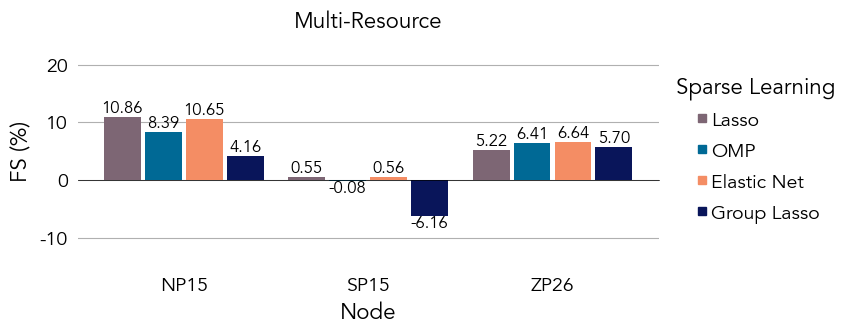

In [29]:
def _make_fs_node_plot(Scores_, ref_, zones_p_, legend_labels_, legend_title, colors_, 
                       ndecimals = 0,
                       score     = 'RMSE',
                       xlabel    = '',
                       ylabel    = '', 
                       title     = '', 
                       letter    = '', 
                       suptitle  = '', 
                       save      = False, 
                       legend    = False, 
                       filename  = 'noname.pdf'):
    
    #resources_      = Scores_['resource'].unique()
    sparse_methods_ = Scores_['sparse_method'].unique()
    zones_          = Scores_['zone'].unique()
    print(zones_)
    
    x_ = np.linspace(0, .333*len(sparse_methods_), len(sparse_methods_))

    width  = 0.4
    offset = 2.
    
    fig = plt.figure(figsize = (len(zones_)*2.5, 3.))
    ax  = plt.subplot(111)
    
    plt.suptitle(suptitle, fontsize = 20, 
                           y        = 1.075)
    
    plt.title(title, fontsize = 16)

    ticks_  = []
    values_ = []
    j = 0
    for zone in zones_:
        i = 0
        for sparse_method in sparse_methods_:
            
            idx_1_ = (Scores_['sparse_method'] == sparse_method) & (Scores_['zone'] == zone) & (Scores_['score'] == score)
            idx_2_ = (ref_['method'] == 'CAISO') & (ref_['zone'] == zone) 
            #y      = np.around(100*(1. -  Scores_.loc[idx_1_, 'RMSE'].sum()/ref_.loc[idx_2_, 'RMSE'].sum()), ndecimals)

            idx_1_ = (Scores_['sparse_method'] == sparse_method) & (Scores_['zone'] == zone)
            y      = np.around(100*(1. -  Scores_.loc[idx_1_].groupby(['resource']).min().reset_index()['RMSE'].sum()/ref_.loc[idx_2_, 'RMSE'].sum()), ndecimals)

            p = plt.bar(x_[i], y, width, color  = colors_[i], 
                                         zorder = 9, 
                                         align  = 'center')
                
            plt.bar_label(p, labels = [f'{x:,.2f}' for x in p.datavalues], size = 12, rotation = 0)
           
            i += 1
        
        ticks_.append(x_.mean())

        x_ += offset
        j  += 1
 
    
    plt.xticks(ticks_[:len(zones_)], zones_, fontsize = 10)
    
    plt.ylim(-15, 25)

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        plt.legend(handles        = legend_, 
                   title          = legend_title, 
                   prop           = {'size': 14}, 
                   title_fontsize = 16,
                   ncol           = 1, 
                   columnspacing  = 0., 
                   handletextpad  = 0.,  
                   bbox_to_anchor = [1., .9],
                   frameon        = False)
    
    plt.grid(axis = 'y')

    ax.xaxis.set_tick_params(labelsize = 14, left = False)
    ax.yaxis.set_tick_params(labelsize = 14, left = False)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    
    plt.ylabel(ylabel, fontsize = 16)
    plt.xlabel(xlabel, fontsize = 16)
    
    ax.axhline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)

    # ax.text(-1.25, y_max*1.1, letter, fontsize = 20, 
    #                                   weight   = "bold")
    
    if save:
        plt.savefig(path_to_images + filename, bbox_inches = 'tight',
                                               dpi         = 250)
    plt.show()
    
zones_p_ = ['PG&E', 'SDGE', 'SCE']

_make_fs_node_plot(ts_scores_, ref_, zones_p_, 
                   colors_        = colors_1_, 
                   score          = 'RMSE',
                   ndecimals      = 2, 
                   legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
                   xlabel         = 'Node',
                   ylabel         = 'FS (%)',
                   legend_title   = 'Sparse Learning',
                   save           = True, 
                   legend         = True, 
                   suptitle       = r'', 
                   title          = r'Multi-Resource',
                   filename       = 'multisource_fs_node_RMSE.png')

### Multisource Model Resournce-level Forecasting Skill

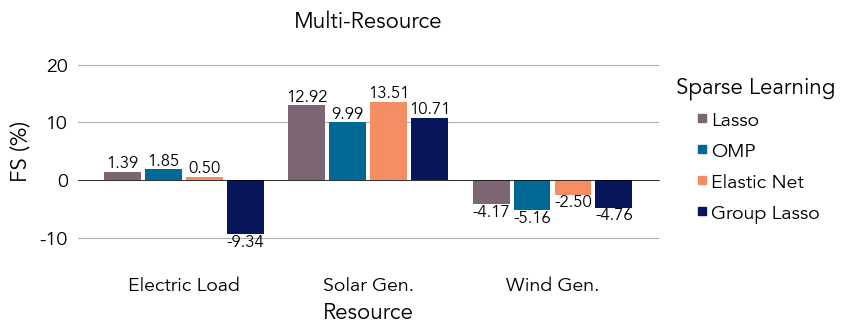

In [9]:
def _make_fs_resource_plot(Scores_, ref_, zones_p_, legend_labels_, legend_title, colors_, 
                           ndecimals = 0,
                           score     = 'RMSE',
                           xlabel    = '',
                           ylabel    = '', 
                           title     = '', 
                           letter    = '', 
                           suptitle  = '', 
                           save      = False, 
                           legend    = False, 
                           filename  = 'noname.pdf'):
    
    resources_      = Scores_['resource'].unique()
    sparse_methods_ = Scores_['sparse_method'].unique()
    
    x_ = np.linspace(0, .333*len(sparse_methods_), len(sparse_methods_))

    width  = 0.4
    offset = 2.
    
    fig = plt.figure(figsize = (len(zones_)*2.5, 3.))
    ax  = plt.subplot(111)
    
    plt.suptitle(suptitle, fontsize = 20, 
                           y        = 1.075)
    
    plt.title(title, fontsize = 16)

    ticks_  = []
    values_ = []
    j = 0

    for resource in resources_:
        i = 0
        for sparse_method in sparse_methods_:
            
            #idx_1_ = (Scores_['sparse_method'] == sparse_method) & (Scores_['resource'] == resource) & (Scores_['score'] == score)
            idx_2_ = (ref_['method'] == 'CAISO') & (ref_['resource'] == resource)
            #y      = np.around(100*(1. -  Scores_.loc[idx_1_, 'RMSE'].sum()/ref_.loc[idx_2_, 'RMSE'].sum()), ndecimals)
            
            
            idx_1_ = (Scores_['sparse_method'] == sparse_method) & (Scores_['resource'] == resource)
            y      = np.around(100*(1. -  Scores_.loc[idx_1_].groupby(['zone']).min().reset_index()['RMSE'].sum()/ref_.loc[idx_2_, 'RMSE'].sum()), ndecimals)
            
            p = plt.bar(x_[i], y, width, color  = colors_[i], 
                                         zorder = 9, 
                                         align  = 'center')
                
            plt.bar_label(p, labels = [f'{x:,.2f}' for x in p.datavalues], size = 12, rotation = 0)
           
            i += 1
        
        ticks_.append(x_.mean())

        x_ += offset
        j  += 1
 
    
    plt.xticks(ticks_[:len(zones_p_)], zones_p_, fontsize = 10)
    
    plt.ylim(-15, 25)

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        plt.legend(handles        = legend_, 
                   title          = legend_title, 
                   prop           = {'size': 14}, 
                   title_fontsize = 16,
                   ncol           = 1, 
                   columnspacing  = 0., 
                   handletextpad  = 0.,  
                   bbox_to_anchor = [1., .9],
                   frameon        = False)

    plt.grid(axis = 'y')

    ax.xaxis.set_tick_params(labelsize = 14, left = False)
    ax.yaxis.set_tick_params(labelsize = 14, left = False)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    
    plt.ylabel(ylabel, fontsize = 16)
    plt.xlabel(xlabel, fontsize = 16)
    
    ax.axhline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)
    
    if save:
        plt.savefig(path_to_images + filename, bbox_inches = 'tight',
                                               dpi         = 250)
    plt.show()
    
zones_p_ = ['Electric Load', 'Solar Gen.', 'Wind Gen.']

_make_fs_resource_plot(ts_scores_, ref_, zones_p_, 
                       colors_        = colors_1_, 
                       score          = 'ES',
                       ndecimals      = 2, 
                       legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
                       xlabel         = 'Resource',
                       ylabel         = 'FS (%)',
                       legend_title   = 'Sparse Learning',
                       save           = True, 
                       legend         = True, 
                       suptitle       = r'', 
                       title          = r'Multi-Resource',
                       filename       = 'multisource_fs_resource_RMSE.png')

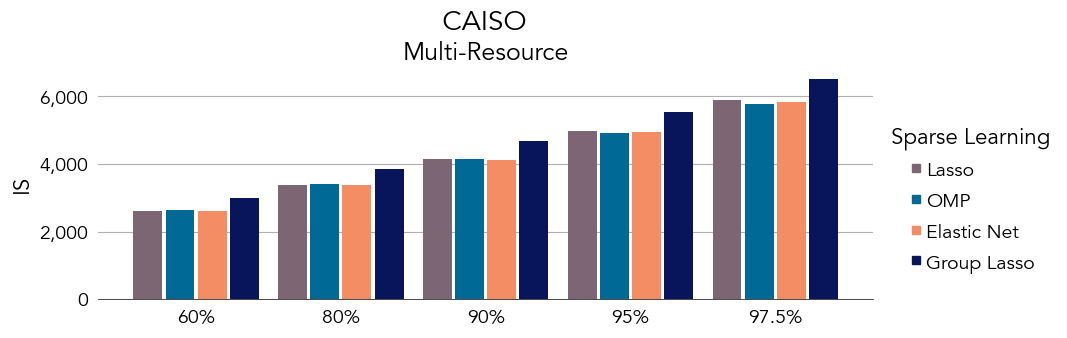

In [140]:
def _make_interval_scores_plot(Scores_, zones_p_, legend_labels_, legend_title, colors_, 
                               ndecimals       = 2, 
                               score           = '', 
                               xlabel          = '',
                               ylabel          = '', 
                               title           = '', 
                               suptitle        = '', 
                               label_font_size = 10.,
                               labels          = True,
                               save            = False, 
                               legend          = False, 
                               filename        = 'noname.pdf'):
    

    interval_scores_ = ['IS60','IS80','IS90','IS95', 'IS975']
    dense_methods_   = Scores_['dense_method'].unique()
    sparse_methods_  = Scores_['sparse_method'].unique()
    zones_ = ['NP15', 'SP15', 'ZP26']
    
    x_ = np.linspace(0, .333*len(sparse_methods_), len(sparse_methods_))

    width  = 0.4
    offset = 2.
    
    fig = plt.figure(figsize = (len(interval_scores_)*2., 3.))
    ax  = plt.subplot(111)
    
    plt.suptitle(suptitle, fontsize = 20, 
                           y        = 1.075)
    
    plt.title(title, fontsize = 18)

    ticks_  = []
    values_ = []
    j = 0
    for interval_score in interval_scores_:
        i = 0
        for sparse_method in sparse_methods_:
     
            idx_1_ = (Scores_['score'] == 'IS') & (Scores_['sparse_method'] == sparse_method)

            y = np.around(Scores_.loc[idx_1_, interval_score].sum(), ndecimals)
            p = plt.bar(x_[i], y, width, color  = colors_[i], 
                                         zorder = 9, 
                                         align  = 'center')
             
            if labels:
                plt.bar_label(p, labels = [[f'{x:,.0f}', f'{x:,.1f}', f'{x:,.2f}', f'{x:,.3f}'][ndecimals] for x in p.datavalues], size = label_font_size)
           
            i += 1
        
        ticks_.append(x_.mean())

        x_ += offset
        j  += 1
 
    
    plt.xticks(ticks_[:len(interval_scores_)], ['60%', '80%', '90%', '95%', '97.5%'], fontsize = 10)
    
#     y_min = -.1
#     y_max = np.max(np.array(values_))*1.15
    
#     plt.ylim(y_min, y_max)

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        plt.legend(handles        = legend_, 
                   title          = legend_title, 
                   prop           = {'size': 14}, 
                   title_fontsize = 16,
                   ncol           = 1, 
                   columnspacing  = 0., 
                   handletextpad  = 0.,  
                   bbox_to_anchor = [1., .825],
                   frameon        = False)

    plt.grid(axis = 'y')

    ax.xaxis.set_tick_params(labelsize = 14, left = False)
    ax.yaxis.set_tick_params(labelsize = 14, left = False)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
        
    plt.ylabel('IS', fontsize = 16)
    plt.xlabel(xlabel, fontsize = 16)
    
    ax.axhline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)
    
    if save:
        plt.savefig(path_to_images + filename, bbox_inches = 'tight',
                                               dpi         = 300)
    plt.show()

_make_interval_scores_plot(ts_is_scores_, zones_, 
                           colors_         = colors_1_, 
                           ndecimals       = 0, 
                           legend_labels_  = ['Lasso','OMP','Elastic Net', 'Group Lasso'], 
                           score           = 'IS',
                           legend_title    = 'Sparse Learning',
                           labels          = False,
                           save            = True, 
                           legend          = True, 
                           filename        = 'ms_is.png',
                           suptitle        = '   CAISO',
                           title           = 'Multi-Resource',
                           label_font_size = 9.)

### Multisource Models Scoring Rules - Box Plot

In [11]:
def _load_sample_multisource_scores(zones_, sl_models_, dl_models_, scores_):
    _results = {}
    for zone in zones_:
        _results[zone] = {}

        for score in scores_:
            _results[zone][score] = {}

            for sl_model in sl_models_:
                _results[zone][score][sl_model] = {}

                for dl_model in dl_models_:
                    filename = '{}-{}-{}-{}.pkl'.format(zone, sl_model, dl_model, score)

                    with open(path_to_mdls + filename, 'rb') as f:
                        _model = pickle.load(f)                    

                    _results[zone][score][sl_model][dl_model] = _model['bayesian_scoring_all'][score].to_numpy()

    return _results

_results = _load_sample_multisource_scores(zones_     = zones_, 
                                           sl_models_ = sl_methods_, 
                                           dl_models_ = dl_methods_, 
                                           scores_    = ['ES', 'VS', 'LogS'])

In [12]:
def _plot_box(_results, sl_models_, resources_, score, colors_, y_min          = 0., 
                                                                y_max          = 0., 
                                                                legend_labels_ = [],
                                                                suptitle       = '', 
                                                                title          = '', 
                                                                legend_title   = '', 
                                                                letter         = '',
                                                                legend         = False, 
                                                                save           = False, 
                                                                path           = '',
                                                                filename       = 'unname.pdf'):

    width  = 0.15
    offset = 1.

    x_ = np.linspace(0, width*len(sl_models_), len(sl_models_))


    fig = plt.figure(figsize = (3.5, 3.))
    ax  = plt.subplot(111)

    plt.suptitle(suptitle, fontsize = 17, y = .88)

    plt.title(title, fontsize = 15, y = 0.8)


    ticks_ = []
    for resource in resources_:

        i = 0
        for sl_model in sl_models_:
            data     = _results[resource][score][sl_model]['MTGPR']
            df_      = pd.DataFrame()
            df_['y'] = data
            df_['x'] = x_[i]

            _box = ax.boxplot(df_['y'], positions     = [x_[i]], 
                                        showmeans    = True, 
                                        showfliers   = True, 
                                        patch_artist = True, 
                                        zorder       = 10)
            
            # change outline color
            _box['boxes'][0].set(color = colors_[i], linewidth = .5, edgecolor = 'k', facecolor = colors_[i], alpha = 1.)
            _box['medians'][0].set(color = 'lightgray', zorder = 10)
            _box['means'][0].set(marker = "o", markersize = 5., markeredgewidth = .75, markeredgecolor = 'k', markerfacecolor = 'white')
            _box['fliers'][0].set(marker = "o", markersize = 1.25, markeredgewidth = .5,  markeredgecolor = 'k', markerfacecolor = 'None', alpha = .5)
            _box['whiskers'][0].set(linewidth = .5)
            _box['whiskers'][1].set(linewidth = .5)
            _box['caps'][0].set(linewidth = .5)
            _box['caps'][1].set(linewidth = .5)

            i +=1 

        ticks_.append(x_.mean())
        x_ += offset

    ax.xaxis.set_tick_params(labelsize = 12)
    ax.yaxis.set_tick_params(labelsize = 12)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    plt.ylabel(score, fontsize = 14)
    # plt.xlabel(xlabel, fontsize = 16)

    plt.xticks(ticks_[:len(resources_)], resources_, fontsize = 14)

    plt.ylim(y_min, y_max)
    #plt.xlim(-0.25, 2.75)

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        _leg_1 = plt.legend(handles        = legend_, 
                            title          = legend_title, 
                            prop           = {'size': 12}, 
                            title_fontsize = 14,
                            ncol           = 1, 
                            columnspacing  = 0., 
                            handletextpad  = 0.,  
                            bbox_to_anchor = [.975, .8],
                            frameon        = False)
        ax.add_artist(_leg_1)


    legend_ = []

    legend_.append(Line2D([0], [0], marker          = 'o', 
                                    markerfacecolor = None, 
                                    markeredgecolor = 'k', 
                                    markersize      = 4,
                                    label           = 'median',
                                    color           = "None"))

    legend_.append(Line2D([0], [0], marker          = '_', 
                                    markerfacecolor = "silver", 
                                    markeredgecolor = "silver", 
                                    markersize      = 6,
                                    label           = 'mean',
                                    color           = "None"))
    if legend:
        _leg_2 = plt.legend(handles        = legend_, 
                            prop           = {'size': 10}, 
                            title_fontsize = 14,
                            ncol           = 1, 
                            columnspacing  = 0., 
                            handletextpad  = 0.,  
                            #bbox_to_anchor = [0.35, .45],
                            loc            = 'upper left',
                            frameon        = False)

        ax.add_artist(_leg_2)
        
    plt.grid(axis      = 'y',
             alpha     = .25, 
             linestyle = '-')

    # ax.text(-1., y_max*1.025, letter, fontsize = 16, 
    #                                  weight   = "bold")
        
    sns.despine(trim   = True, 
                offset = 0)
    

    if save:
        plt.savefig(path + filename, bbox_inches = 'tight',
                                     dpi         = 300)


    plt.show()

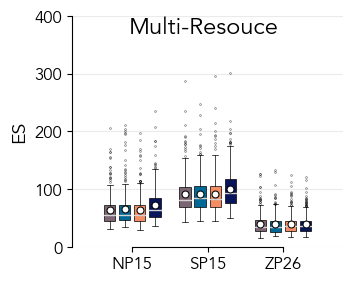

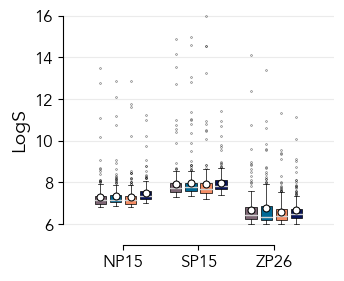

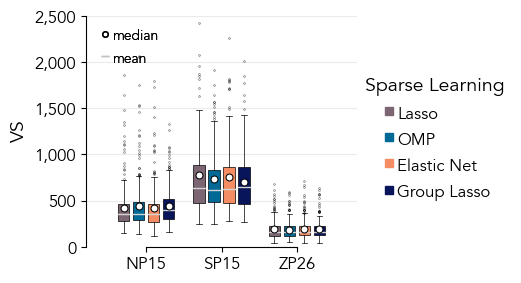

In [13]:
_plot_box(_results, sl_methods_, zones_, score          = 'ES', 
                                         y_min          = 0, 
                                         y_max          = 400, 
                                         legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                         colors_        = colors_1_,
                                         legend         = False, 
                                         legend_title   = 'Sparse Learning', 
                                         save           = True,
                                         suptitle       = 'Multi-Resouce',
                                         title          = ' ',
                                         path           = path_to_images, 
                                         filename       = 'ms_scores_box_ES.png')

_plot_box(_results, sl_methods_, zones_, score          = 'LogS', 
                                         y_min          = 5, 
                                         y_max          = 16.1, 
                                         legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                         colors_        = colors_1_,
                                         legend         = False, 
                                         legend_title   = 'Sparse Learning', 
                                         save           = True,
                                         path           = path_to_images, 
                                         filename       = 'ms_scores_box_LogS.png')

_plot_box(_results, sl_methods_, zones_, score          = 'VS', 
                                         y_min          = 0, 
                                         y_max          = 2500, 
                                         legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                         colors_        = colors_1_,
                                         legend         = True, 
                                         legend_title   = 'Sparse Learning', 
                                         save           = True,
                                         path           = path_to_images, 
                                         filename       = 'ms_scores_box_VS.png')

In [55]:
# def _RMSE(Y_, Y_hat_):
#     return np.array([np.sqrt(np.mean((Y_[:, t] - Y_hat_[:, t])**2)) for t in range(Y_hat_.shape[-1])])

# def _load_test_scores(zones_, resources_, sl_methods_, dl_methods_, scores_, bay_scores_, path):
    
#     Scores_ = []
#     for score in scores_:
#         for sl_method in sl_methods_:
#             for dl_method in dl_methods_:
#                 for zone, N_resources in zip(zones_, [3, 3, 2]):
#                     meta_ = [sl_method, dl_method, zone, score]

#                     filename = '{}-{}-{}-{}.pkl'.format(zone, sl_method, dl_method, score)
#                     with open(path + filename, 'rb') as f:
#                         _model = pickle.load(f)  
                        
#                     IS = np.array([_model['bayesian_scoring'][IS] 
#                                    for IS in ['IS60','IS80','IS90','IS95', 'IS975']]).mean()  
                    
#                     Y_      = _model['targets'][:, 0, :] 
#                     Y_iso_  = _model['caiso'][:, 0, :] 
#                     Y_mean_ = _model['mean'][:, 0, :]
#                     for i_resource in range(N_resources - 1):
#                         Y_      -= _model['targets'][:, i_resource + 1, :] 
#                         Y_iso_  -= _model['caiso'][:, i_resource + 1, :] 
#                         Y_mean_ -= _model['mean'][:, i_resource + 1, :] 
                    
#                     FS      = 100*(1. - _RMSE(Y_, Y_mean_).sum()/_RMSE(Y_, Y_iso_).sum())
#                     values_ = [IS, FS]
                    
#                     for bay_score in bay_scores_:
#                         values_.append(float(_model['bayesian_scoring'][bay_score].to_numpy()[0]))

#                     Scores_.append(np.array(meta_ + values_))

#     return pd.DataFrame(np.stack(Scores_), columns = ['sparse_method', 'dense_method', 'zone', 'score', 'IS', 'FS'] + bay_scores_)

# def _load_computing_time(resources_, sl_models_, dl_models_, scores_, path, N_tr):

#     time_ = []
#     for resource in resources_:  
#         for score in scores_:
#             for sl_model in sl_models_:
#                 for dl_model in dl_models_:

#                     filename = '{}-{}-{}-{}.pkl'.format(resource, sl_model, dl_model, score)

#                     with open(path + filename, 'rb') as f:
#                         _model = pickle.load(f)                    
#                     tr = _model['time'].loc['sparse_training', 'time'] + _model['time'].loc['dense_training', 'time']
#                     ts = (_model['time'].loc['testing', 'time'] + _model['time'].loc['prob_testing', 'time'])/N_tr

#                     time_.append([resource, score, sl_model, dl_model, tr, ts])

#     return pd.DataFrame(np.stack(time_), columns = ['resource', 'score', 'sparse_method', 'dense_method', 'train', 'test'])

# path_to_mdls = r'/Users/Guille/Desktop/caiso_power/models/journal_paper_w_sigma_n_lambda-Cal-4/'

# resources_  = ['load', 'solar', 'wind']
# sl_methods_ = ['lasso', 'OMP', 'elastic_net', 'group_lasso']
# dl_methods_ = ['MTGPR']
# zones_      = ['NP15', 'SP15', 'ZP26']
# scores_     = ['LogS', 'ES', 'VS']
# bay_scores_ = ['LogS', 'ES', 'VS', 'IS60','IS80','IS90','IS95', 'IS975']

# ts_scores_ = _load_test_scores(zones_, resources_, sl_methods_, dl_methods_, scores_, bay_scores_, path_to_mdls)

# ts_scores_['LogS'] = ts_scores_['LogS'].astype(float)
# ts_scores_['ES']   = ts_scores_['ES'].astype(float)
# ts_scores_['VS']   = ts_scores_['VS'].astype(float)
# ts_scores_['IS']   = ts_scores_['IS'].astype(float)
# ts_scores_['FS']   = ts_scores_['FS'].astype(float)

# time_ = _load_computing_time(resources_ = zones_, 
#                              sl_models_ = sl_methods_, 
#                              dl_models_ = dl_methods_, 
#                              scores_    = scores_, 
#                              path       = path_to_mdls,
#                              N_tr       = 243)

In [157]:
def _RMSE(Y_, Y_hat_):
    return np.array([np.sqrt(np.mean((Y_[:, t] - Y_hat_[:, t])**2)) for t in range(Y_hat_.shape[-1])])

from scipy.stats import norm, multivariate_normal

# Energy Score across time
def _ES(Y_, Y_hat_):

    N_observation, N_tasks, N_horizons, N_scen = Y_hat_.shape

    score_ = np.zeros((N_observation))
    Y_     = np.concatenate([Y_[:, tsk, ...] for tsk in range(N_tasks)], axis = 1)
    Y_hat_ = np.concatenate([Y_hat_[:, tsk, ...] for tsk in range(N_tasks)], axis = 1)

    for n in range(N_observation):
        Y_p_   = np.tile(Y_[n, :], (N_scen, 1)).T
        frac1_ = np.sqrt(np.diag((Y_hat_[n, :, :] - Y_p_).T @ (Y_hat_[n, :, :] - Y_p_)))
        frac2_ = 0
        for m in range(N_scen):
            frac2_ += np.sqrt(np.sum((Y_hat_[n, :, :].T - Y_hat_[n, :, m])**2, axis = 1))
        score_[n] = (np.sum(frac1_)/N_scen) - (np.sum(frac2_)/(2*(N_scen**2)))
    return score_

# Variogram Score computed across temporal dimensions
def _VS(Y_, Y_hat_, p = .5):
    N_observation, N_tasks, N_horizons, N_scen = Y_hat_.shape
    score_ = np.zeros((N_observation))
    Y_     = np.concatenate([Y_[:, tsk, ...] for tsk in range(N_tasks)], axis = 1)
    Y_hat_ = np.concatenate([Y_hat_[:, tsk, ...] for tsk in range(N_tasks)], axis = 1)
    for n in range(N_observation):
        frac1_ = np.absolute(np.subtract.outer(Y_[n, ], Y_[n, :]))**p
        frac2_ = np.zeros((N_horizons*N_tasks, N_horizons*N_tasks))
        for m in range(N_scen):
            frac2_ += np.absolute(np.subtract.outer(Y_hat_[n, :, m], Y_hat_[n, :, m]))**p
        score_[n] = np.sum((frac1_ - (frac2_/N_scen))**2)
    return score_

def _IS(Y_, M_, S2_, z, alpha):
    
    # Interval Score
    def __IS(y_, alpha, lower_, upper_):
        score_  = (upper_ - lower_)
        score_ += (2./alpha)*(lower_ - y_) * (1*(y_ < lower_))
        score_ += (2./alpha)*(y_ - upper_) * (1*(y_ > upper_))
        return score_
    # 95% CI: z = 1.96; alpha = 0.05
    # 90% CI: z = 1.645; alpha = 0.1
    N_observation, N_horizons = M_.shape
    # Y_     = np.concatenate([Y_[:, tsk, 8:16] for tsk in [3, 4, 5]], axis = 1)
    # M_     = np.concatenate([M_[:, tsk, 8:16] for tsk in [3, 4, 5]], axis = 1)
    # S2_    = np.concatenate([S2_[:, tsk, 8:16] for tsk in [3, 4, 5]], axis = 1)
    score_ = np.zeros((N_observation,))
    for n in range(N_observation):
        score_[n] = __IS(Y_[n, :], alpha, lower_ = M_[n, :] - z*np.sqrt(S2_[n, :]),
                                          upper_ = M_[n, :] + z*np.sqrt(S2_[n, :])).sum()
    return score_

def _RMSE(Y_, Y_hat_):
    return np.array([np.sqrt(np.mean((Y_[:, t] - Y_hat_[:, t])**2)) for t in range(Y_hat_.shape[-1])])

def _load_test_scores(zones_, sl_methods_, dl_methods_, scores_, path):
    
    df_ = []
    for zone, N_resources in zip(zones_, [3, 3, 2]):
        print(zone)
        for score in scores_:
            for sl_method in sl_methods_:
                for dl_method in dl_methods_:
                    
                    with open(path + '{}-{}-{}-{}.pkl'.format(zone, sl_method, dl_method, score), 'rb') as f:
                        _model = pickle.load(f)  
                    
                    N_samples, N_tasks, N_horizons = _model['mean'].shape
                    Z = N_samples*N_tasks*N_horizons
                    
                    Y_      = _model['targets'][:, 0, :] 
                    Y_iso_  = _model['caiso'][:, 0, :] 
                    Y_mean_ = _model['mean'][:, 0, :]
                    Y_var_  = _model['variance'][:, 0, :]
                    for i_resource in range(N_resources - 1):
                        Y_      -= _model['targets'][:, i_resource + 1, :] 
                        Y_iso_  -= _model['caiso'][:, i_resource + 1, :] 
                        Y_mean_ -= _model['mean'][:, i_resource + 1, :] 
                        Y_var_  += _model['variance'][:, i_resource + 1, :] 

                    tr = _model['time'].loc['sparse_training', 'time'] + _model['time'].loc['dense_training', 'time']
                    ts = (_model['time'].loc['testing', 'time'] + _model['time'].loc['prob_testing', 'time'])/N_samples
                    
                    IS975 = _IS(Y_, Y_mean_, Y_var_, z = 2.243, alpha = 0.025).sum()/Z
                    IS95  = _IS(Y_, Y_mean_, Y_var_, z = 1.959, alpha = 0.05).sum()/Z
                    IS90  = _IS(Y_, Y_mean_, Y_var_, z = 1.645, alpha = 0.1).sum()/Z
                    IS80  = _IS(Y_, Y_mean_, Y_var_, z = 1.282, alpha = 0.2).sum()/Z
                    IS60  = _IS(Y_, Y_mean_, Y_var_, z = 0.842, alpha = 0.4).sum()/Z

                    #LogS = -z_.sum()/Z
                    RMSE = _RMSE(Y_, Y_mean_).mean()
                    FS   = 100*(1. - _RMSE(Y_, Y_mean_).sum()/_RMSE(Y_, Y_iso_).sum())
                    ES   = _ES(_model['targets'], _model['samples']).sum()/Z
                    VS   = _VS(_model['targets'], _model['samples']).sum()/Z
                    IS   = IS60 + IS80 + IS90 + IS95 + IS975 

                    df_.append([sl_method, dl_method, zone, score, RMSE, FS, ES, VS, IS, IS60, IS80, IS90, IS95, IS975, tr, ts])

    return pd.DataFrame(df_, columns = ['sparse_method', 'dense_method', 'zone', 'score', 'RMSE', 'FS', 'ES', 'VS', 'IS', 'IS60', 'IS80', 'IS90','IS95', 'IS975', 'train', 'test'])


path_to_mdls = r'/Users/Guille/Desktop/caiso_power/models/journal_paper_w_sigma_n_lambda-Cal-2/'

resources_  = ['load', 'solar', 'wind']
sl_methods_ = ['lasso', 'OMP', 'elastic_net', 'group_lasso']
dl_methods_ = ['MTGPR']
zones_      = ['NP15', 'SP15', 'ZP26']
scores_     = ['ES', 'VS', 'IS']

ts_scores_ = _load_test_scores(zones_, sl_methods_, dl_methods_, scores_, path_to_mdls)

ts_scores_['RMSE']  = ts_scores_['RMSE'].astype(float)
ts_scores_['FS']    = ts_scores_['FS'].astype(float)
ts_scores_['ES']    = ts_scores_['ES'].astype(float)
ts_scores_['VS']    = ts_scores_['VS'].astype(float)
ts_scores_['IS']    = ts_scores_['IS'].astype(float)
ts_scores_['IS60']  = ts_scores_['IS60'].astype(float)
ts_scores_['IS80']  = ts_scores_['IS80'].astype(float)
ts_scores_['IS90']  = ts_scores_['IS90'].astype(float)
ts_scores_['IS95']  = ts_scores_['IS95'].astype(float)
ts_scores_['IS975'] = ts_scores_['IS975'].astype(float)
ts_scores_['train'] = ts_scores_['train'].astype(float)
ts_scores_['test']  = ts_scores_['test'].astype(float)

#print(ts_scores_.loc[(ts_scores_['score'] == 'ES') & (ts_scores_['resource'] == 'load')])

NP15
SP15
ZP26


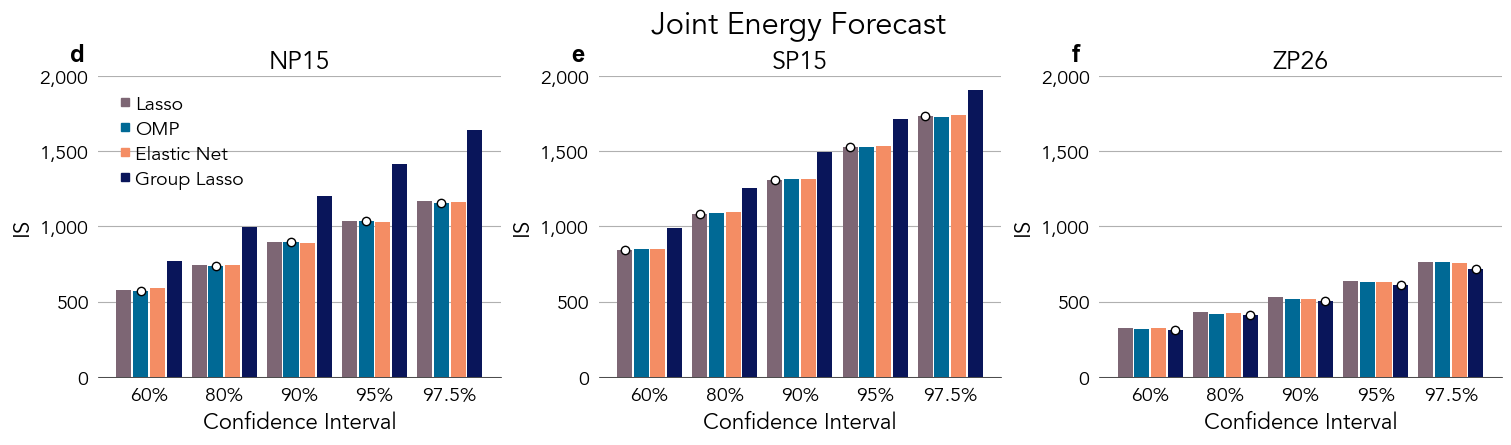

In [216]:
def _plot_interval_scores(ax, Scores_, colors_, zone,
                          legend_labels_ = [], 
                          legend_title   = '', 
                          score          = '', 
                          xlabel         = 'Confidence Interval',
                          ylabel         = '', 
                          title          = '', 
                          y_max          = 5000.,
                          legend         = False):
    

    interval_scores_ = ['IS60','IS80','IS90','IS95', 'IS975']
    dense_methods_  = Scores_['dense_method'].unique()
    sparse_methods_ = Scores_['sparse_method'].unique()
    
    x_ = np.linspace(0, .333*len(sparse_methods_), len(sparse_methods_))

    ax.set_title(title, size = 18)
    width  = 0.4
    offset = 2.

    ticks_  = []
    values_ = []
    j = 0
    for interval_score in interval_scores_:
        i = 0
        for sparse_method in sparse_methods_:
     
            idx_1_ = (Scores_['zone'] == zone) & (Scores_['score'] == 'IS') & (Scores_['sparse_method'] == sparse_method)

     
            idx_1_ = (Scores_['dense_method'] == dense_method) & (Scores_['resource'] == resource) & (Scores_['score'] == score)
            df_ = Scores_.loc[idx_1_ & (Scores_['IS'] == Scores_.loc[idx_1_, 'IS'].min())]
            
            p = ax.bar(x_[i], Scores_.loc[idx_1_, interval_score].min(), width, color  = colors_[i], 
                                         zorder = 9, 
                                         align  = 'center')
            
            if Scores_.loc[idx_1_, 'IS'].min() == Scores_.loc[(Scores_['zone'] == zone) & (Scores_['score'] == score), 'IS'].min():
                ax.scatter(x_[i], Scores_.loc[idx_1_, interval_score].min(), marker   = 'o', 
                                                                             color     = 'w', 
                                                                             edgecolor = 'k', 
                                                                             lw        = 1., 
                                                                             zorder    = 10)

            i += 1
        
        ticks_.append(x_.mean())

        x_ += offset
        j  += 1
 
    
    ax.set_xticks(ticks_[:len(interval_scores_)], ['60%', '80%', '90%', '95%', '97.5%'], fontsize = 10)
    
    ax.set_ylim(0, y_max)

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        ax.legend(handles        = legend_, 
                  title          = legend_title, 
                  prop           = {'size': 14}, 
                  title_fontsize = 16,
                  ncol           = 1, 
                  columnspacing  = 0., 
                  handletextpad  = 0.,  
                  #bbox_to_anchor = [1., .825],
                  loc = "upper left",
                  labelspacing = .2,
                  frameon        = False)

    ax.grid(axis = 'y')

    ax.xaxis.set_tick_params(labelsize = 14, left = False)
    ax.yaxis.set_tick_params(labelsize = 14, left = False)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
        
    ax.set_ylabel('IS', fontsize = 16)
    ax.set_xlabel(xlabel, fontsize = 16)
    
    ax.axhline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)

fig, _ax = plt.subplot_mosaic([['d', 'e', 'f']], layout = 'constrained', figsize = (15, 4))

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom', 
                             family    = "Arial")
    
_plot_interval_scores(_ax['d'], ts_scores_, colors_1_, 
                      zone            = 'NP15', 
                      legend_labels_  = ['Lasso','OMP','Elastic Net', 'Group Lasso'], 
                      score           = 'IS',
                      title           = 'NP15',
                      legend          = True, 
                      y_max           = 2000)

_plot_interval_scores(_ax['e'], ts_scores_, colors_1_, 
                      zone            = 'SP15', 
                      legend_labels_  = ['Lasso','OMP','Elastic Net', 'Group Lasso'], 
                      score           = 'IS',
                      title           = 'SP15',
                      legend          = False, 
                      y_max           = 2000)


_plot_interval_scores(_ax['f'], ts_scores_, colors_1_, 
                      zone            = 'ZP26', 
                      legend_labels_  = ['Lasso','OMP','Elastic Net', 'Group Lasso'], 
                      score           = 'IS',
                      title           = 'ZP26',
                      legend          = False, 
                      y_max           = 2000)

plt.suptitle('          Joint Energy Forecast', fontsize = 22, y = 1.075)

plt.savefig(path_to_images + f'jt_IS.pdf', bbox_inches = 'tight',
                                            dpi         = 300)

plt.show()

In [201]:
def _plot_results(ax, ts_scores_, sl_models_, zones_, score, criteria, colors_, 
                  units        = 1.,
                  y_min        = 0., 
                  y_max        = 0., 
                  legend_labels_ = [],
                  suptitle     = '', 
                  title        = '', 
                  legend_title = '', 
                  letter       = '',
                  legend       = False, 
                  decimals     = False):

    markers_  = ['o', 'p', '^',]

    width  = 0.15
    offset = 1.

    x_ = np.linspace(0, width*len(sl_models_), len(sl_models_))

    ticks_ = []
    j = 0
    dl_model = 'MTGPR'
    for zone in zones_:

        i = 0
        y_ = []
        for sl_model in sl_models_:

            idx_1_ = (ts_scores_['zone'] == zone) & (ts_scores_['score'] == criteria)
            idx_2_ = (ts_scores_['sparse_method'] == sl_model) & (ts_scores_['dense_method'] == dl_model)

            y_.append(ts_scores_.loc[idx_1_ & idx_2_, score].min())
            
            if ts_scores_.loc[idx_1_, score].min() == ts_scores_.loc[idx_1_ & idx_2_, score].min():
                if score == criteria:
                    ax.scatter(x_[i], y_[-1]/units, marker = markers_[j], s = 350, edgecolor = 'k', lw = 1., color = colors_[i], zorder = 10)
                else:
                    ax.scatter(x_[i], y_[-1]/units, marker = markers_[j], s = 350, edgecolor = 'w', lw = .5, color = colors_[i], zorder = 10)
            else:
                ax.scatter(x_[i], y_[-1]/units, marker = markers_[j], s = 250, edgecolor = 'w', lw = .5, color = colors_[i], zorder = 10)

            i +=1 
        ax.plot(x_, y_, lw = 1., zorder = 9, marker = '.', color = 'k')
        j += 1
        ticks_.append(x_.mean())
        x_ += offset

    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    if decimals: ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.2f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    ax.set_ylabel(score, fontsize = 16)

    ax.set_xticks(ticks_[:len(zones_)], zones_, fontsize = 18)

    ax.set_ylim(y_min, y_max)

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        _leg_1 = plt.legend(handles        = legend_, 
                            title          = legend_title, 
                            prop           = {'size': 12}, 
                            title_fontsize = 14,
                            ncol           = 1, 
                            columnspacing  = 0., 
                            handletextpad  = 0.,  
                            bbox_to_anchor = [.975, .8],
                            frameon        = False)
        ax.add_artist(_leg_1)


    legend_ = []

    legend_.append(Line2D([0], [0], marker          = 'o', 
                                    markerfacecolor = None, 
                                    markeredgecolor = 'k', 
                                    markersize      = 4,
                                    label           = 'median',
                                    color           = "None"))

    legend_.append(Line2D([0], [0], marker          = '_', 
                                    markerfacecolor = "silver", 
                                    markeredgecolor = "silver", 
                                    markersize      = 6,
                                    label           = 'mean',
                                    color           = "None"))
    if legend:
        _leg_2 = plt.legend(handles        = legend_, 
                            prop           = {'size': 14}, 
                            title_fontsize = 14,
                            ncol           = 1, 
                            columnspacing  = 0., 
                            handletextpad  = 0.,  
                            bbox_to_anchor = [0.35, .65],
                            #loc            = 'upper left',
                            frameon        = False)

        ax.add_artist(_leg_2)
    
    ax.grid(axis      = 'y', 
            alpha     = .5, 
            linestyle = '-')
    
def _plot_time(ax, time_, score, colors_, legend, 
               y_min = 1, 
               x_max = 1):

    #markers_       = ['o', 'p', '^', 'd']
    markers_       = ['D', '8', 'h']
    legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso']

    idx_1_ = time_['score'] == score

    time_['train'] = time_['train'].astype(float)
    time_['test']  = time_['test'].astype(float)


    i = 0
    for sl_method in time_['sparse_method'].unique():

        idx_2_ = time_['sparse_method'] == sl_method

        j = 0
        for resource in time_['zone'].unique():

            idx_3_  = time_['zone'] == resource
            time_p_ = time_.loc[idx_1_ & idx_2_ & idx_3_]

            ax.scatter(time_p_['test'], time_p_['train'], s         = 300., 
                                                          marker    = markers_[j], 
                                                          edgecolor = 'k',
                                                          lw        = .5, 
                                                          alpha     = 0.6,
                                                          facecolor = colors_[i], clip_on = False)

            j += 1
        i +=1

    ax.spines[['right', 'top']].set_visible(False)

    ax.set_xscale('symlog')
    ax.set_yscale('symlog')

    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)

    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_minor_formatter(NullFormatter())

    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_minor_formatter(NullFormatter())

    ax.set_ylabel('Training Time (s)', fontsize = 16)
    ax.set_xlabel('Testing Time (s)', fontsize = 16)


    legend_title = "Sparse Learning"

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = "k", 
                                        markersize      = 10,
                                        markeredgewidth = .5,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        _leg_1 = plt.legend(handles        = legend_, 
                            title          = legend_title, 
                            prop           = {'size': 14}, 
                            title_fontsize = 16,
                            ncol           = 1, 
                            columnspacing  = 0.5, 
                            handletextpad  = 0.5,  
                            bbox_to_anchor = [.5, .65],
                            frameon        = False)
        ax.add_artist(_leg_1)

    legend_ = []

    legend_.append(Line2D([0], [0], marker          = 'D', 
                                    markerfacecolor = 'None', 
                                    color           = "None",
                                    markeredgecolor = 'k', 
                                    markersize      = 12,
                                    markeredgewidth = .5,
                                    label           = 'NP15'))

    legend_.append(Line2D([0], [0], marker          = '8', 
                                    markerfacecolor = 'None', 
                                    color           = "None",
                                    markeredgecolor = "k", 
                                    markersize      = 15,
                                    markeredgewidth = .5,
                                    label           = 'SP15'))

    legend_.append(Line2D([0], [0], marker          = 'h', 
                                    markerfacecolor = 'None', 
                                    color           = "None",
                                    markeredgecolor = "k", 
                                    markersize      = 15,
                                    markeredgewidth = .5,
                                    label           = 'ZP26'))
    
    ax.set_ylim(1000, 100000)
    ax.set_xlim(1, x_max)

    if legend:
        _leg_2 = ax.legend(handles        = legend_, 
                            prop           = {'size': 12}, 
                            title_fontsize = 14,
                            ncol           = 4, 
                            columnspacing  = 0.5, 
                            handletextpad  = 0.25,  
                            bbox_to_anchor = [1., .125],
                            frameon        = False)
        ax.add_artist(_leg_2)
        
        
def _plot_node_fs(ax, Scores_, zones_, colors_, 
                  legend_labels_ = [], 
                  legend_title   = '', 
                  score          = 'RMSE',
                  xlabel         = '',
                  ylabel         = '', 
                  legend         = False, 
                  y_min          = -20, 
                  y_max          = 20):
    
    sparse_methods_ = Scores_['sparse_method'].unique()
    
    x_ = np.linspace(0, .333*len(sparse_methods_), len(sparse_methods_))

    width  = 0.4
    offset = 2.

    ticks_  = []
    values_ = []
    j = 0
    for zone in zones_:
        i = 0
        for sparse_method in sparse_methods_:
            
            idx_1_ = (Scores_['sparse_method'] == sparse_method) & (Scores_['zone'] == zone) & (Scores_['score'] == score)
            
            p = ax.bar(x_[i], Scores_.loc[idx_1_, 'FS'].min(), width, 
                       color  = colors_[i], 
                       zorder = 9, 
                       align  = 'center')
                
            ax.bar_label(p, labels = [f'{x:,.2f}' for x in p.datavalues], size = 12, rotation = 0)
           
            i += 1
        
        ticks_.append(x_.mean())

        x_ += offset
        j  += 1
 
    
    ax.set_xticks(ticks_[:len(zones_)], zones_, fontsize = 10)
    
    ax.set_ylim(y_min, y_max)

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = colors_[i], 
                                        markersize      = 6,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        plt.legend(handles        = legend_, 
                   title          = legend_title, 
                   prop           = {'size': 14}, 
                   title_fontsize = 16,
                   ncol           = 1, 
                   columnspacing  = 0., 
                   handletextpad  = 0.,  
                   bbox_to_anchor = [1., .9],
                   frameon        = False)
    
    ax.grid(axis = 'y')

    ax.xaxis.set_tick_params(labelsize = 14, left = False)
    ax.yaxis.set_tick_params(labelsize = 14, left = False)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    
    ax.set_ylabel(ylabel, fontsize = 16)
    ax.set_xlabel(xlabel, fontsize = 16)
    
    ax.axhline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)

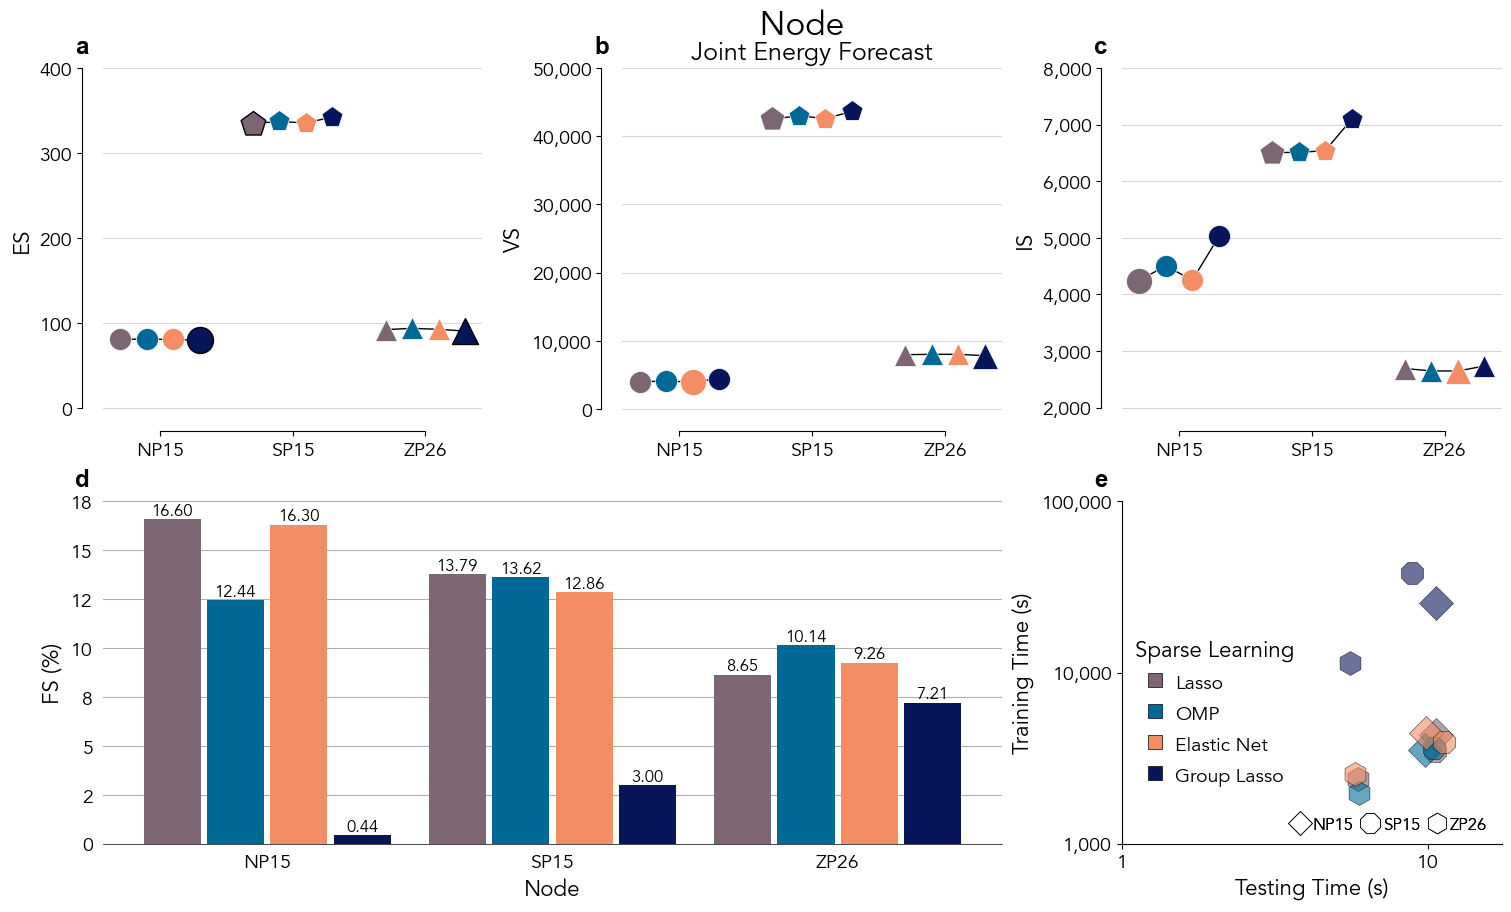

In [208]:
criteria = 'ES'

fig, _ax = plt.subplot_mosaic([['a', 'b', 'c'], ['d', 'd', 'e']], layout = 'constrained', figsize = (15, 8.75))

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom', 
                             family    = "Arial")

_plot_results(_ax['a'], ts_scores_, sl_methods_, zones_, criteria       = criteria,
                                                         score          = 'ES', 
                                                         y_min          = -3, 
                                                         y_max          = 400, 
                                                         legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                         colors_        = colors_1_,
                                                         legend_title   = 'Sparse Learning', 
                                                         legend         = False, 
                                                         decimals       = False)

_ax['b'].set_title('Joint Energy Forecast', fontsize = 18, y = 1.)

sns.despine(trim = True, offset = 15, ax = _ax['a'])

_plot_results(_ax['b'], ts_scores_, sl_methods_, zones_, criteria       = criteria,
                                                         score          = 'VS', 
                                                         y_min          = -200, 
                                                         y_max          = 50000, 
                                                         legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                         colors_        = colors_1_,
                                                         legend_title   = 'Sparse Learning', 
                                                         legend         = False, 
                                                         decimals       = False)

sns.despine(trim = True, offset = 15, ax = _ax['b'])

_plot_results(_ax['c'], ts_scores_, sl_methods_, zones_, criteria       = criteria,
                                                         score          = 'IS', 
                                                         y_min          = 1950, 
                                                         y_max          = 8000, 
                                                         legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                         colors_        = colors_1_,
                                                         legend_title   = 'Sparse Learning', 
                                                         legend         = False, 
                                                         decimals       = False)

sns.despine(trim = True, offset = 15, ax = _ax['c'])

plt.suptitle('          Node', fontsize = 24, y = 1.025)

_plot_node_fs(_ax['d'], ts_scores_, zones_, colors_1_, 
              score          = criteria, 
              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
              xlabel         = 'Node',
              ylabel         = 'FS (%)',
              legend_title   = 'Sparse Learning',
              legend         = True,
              y_min          = 0, 
              y_max          = 17.5)

_plot_time(_ax['e'], ts_scores_, 
           score    = criteria, 
           colors_  = colors_1_, 
           legend   = True, 
           x_max    = 20)

plt.savefig(path_to_images + f'jt_model_selection_{criteria}.pdf', bbox_inches = 'tight',
                                                                    dpi         = 300)

plt.show()

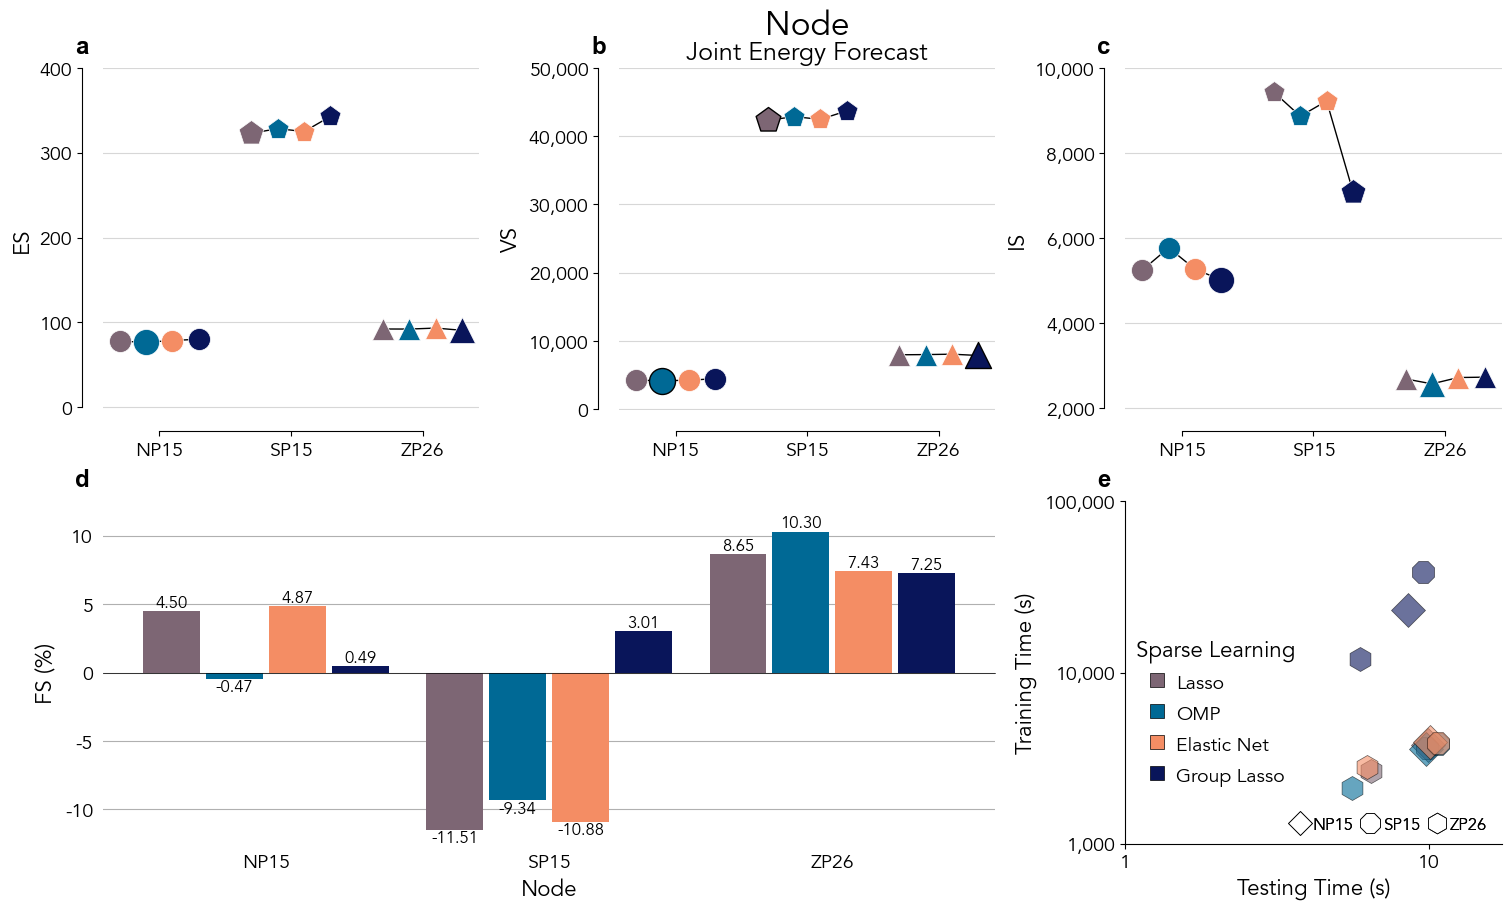

In [203]:
criteria = 'VS'

fig, _ax = plt.subplot_mosaic([['a', 'b', 'c'], ['d', 'd', 'e']], layout = 'constrained', figsize = (15, 8.75))

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom', 
                             family    = "Arial")

_plot_results(_ax['a'], ts_scores_, sl_methods_, zones_, criteria       = criteria,
                                                         score          = 'ES', 
                                                         y_min          = -4, 
                                                         y_max          = 400, 
                                                         legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                         colors_        = colors_1_,
                                                         legend_title   = 'Sparse Learning', 
                                                         legend         = False, 
                                                         decimals       = False)

_ax['b'].set_title('Joint Energy Forecast', fontsize = 18, y = 1.)

sns.despine(trim = True, offset = 15, ax = _ax['a'])

_plot_results(_ax['b'], ts_scores_, sl_methods_, zones_, criteria       = criteria,
                                                         score          = 'VS', 
                                                         y_min          = -200, 
                                                         y_max          = 50000, 
                                                         legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                         colors_        = colors_1_,
                                                         legend_title   = 'Sparse Learning', 
                                                         legend         = False, 
                                                         decimals       = False)

sns.despine(trim = True, offset = 15, ax = _ax['b'])

_plot_results(_ax['c'], ts_scores_, sl_methods_, zones_, criteria       = criteria,
                                                         score          = 'IS', 
                                                         y_min          = 1950, 
                                                         y_max          = 10000, 
                                                         legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                         colors_        = colors_1_,
                                                         legend_title   = 'Sparse Learning', 
                                                         legend         = False, 
                                                         decimals       = False)

sns.despine(trim = True, offset = 15, ax = _ax['c'])

plt.suptitle('           Node', fontsize = 24, y = 1.025)

_plot_node_fs(_ax['d'], ts_scores_, zones_, colors_1_, 
              score          = criteria, 
              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
              xlabel         = 'Node',
              ylabel         = 'FS (%)',
              legend_title   = 'Sparse Learning',
              legend         = True,
              y_min          = -12.5, 
              y_max          = 12.5)

_plot_time(_ax['e'], ts_scores_, 
           score    = criteria, 
           colors_  = colors_1_, 
           legend   = True, 
           x_max    = 20)

plt.savefig(path_to_images + f'jt_model_selection_{criteria}.pdf', bbox_inches = 'tight',
                                                                    dpi         = 300)

plt.show()

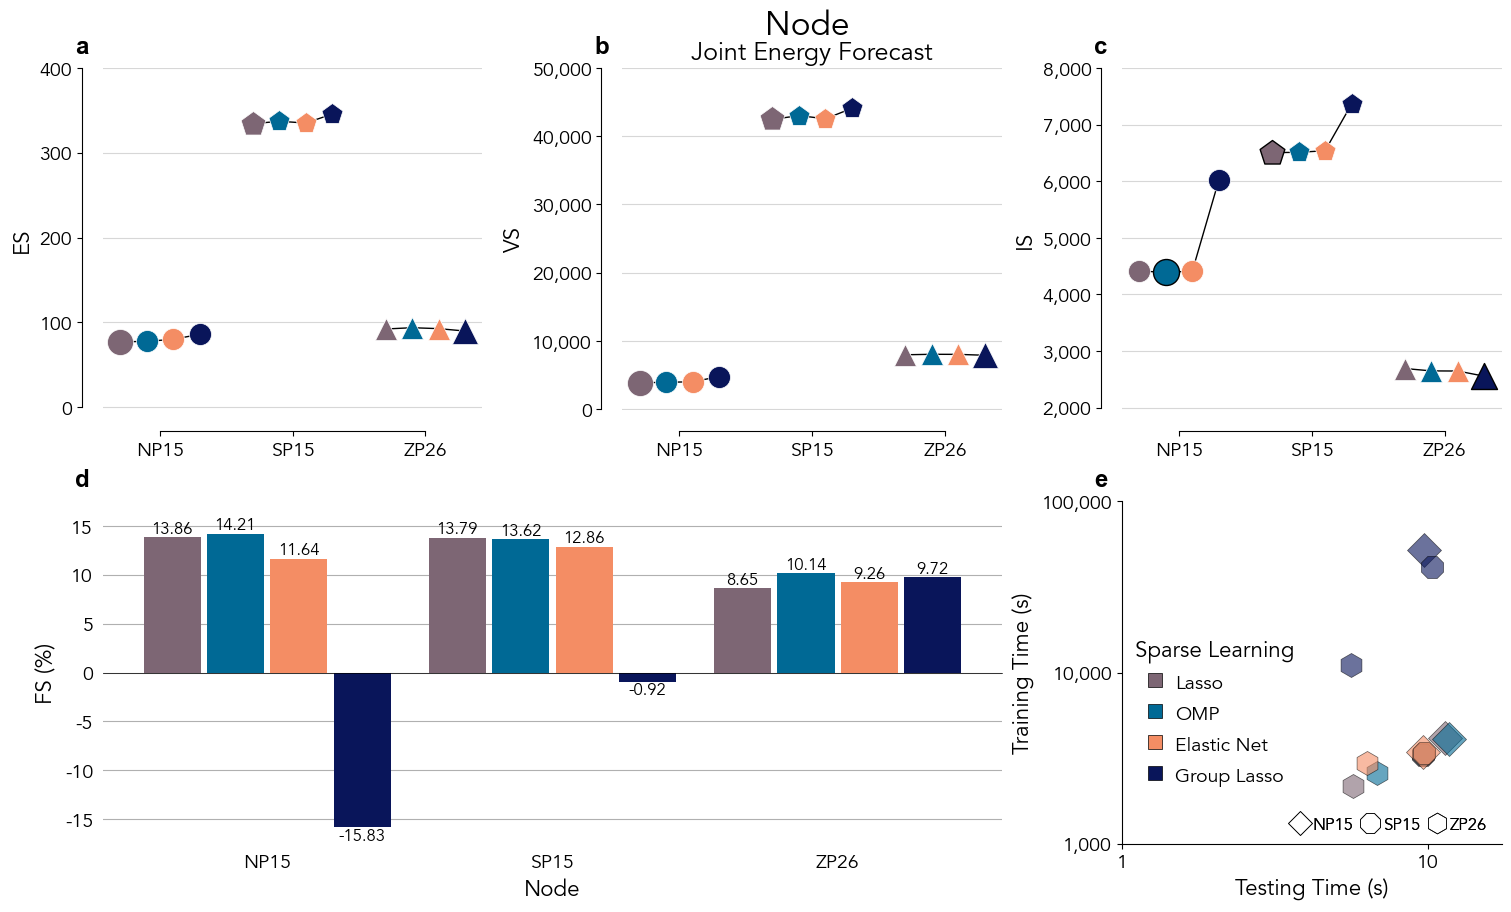

In [204]:
criteria = 'IS'

fig, _ax = plt.subplot_mosaic([['a', 'b', 'c'], ['d', 'd', 'e']], layout = 'constrained', figsize = (15, 8.75))

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom', 
                             family    = "Arial")

_plot_results(_ax['a'], ts_scores_, sl_methods_, zones_, criteria       = criteria,
                                                         score          = 'ES', 
                                                         y_min          = -4, 
                                                         y_max          = 400, 
                                                         legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                         colors_        = colors_1_,
                                                         legend_title   = 'Sparse Learning', 
                                                         legend         = False, 
                                                         decimals       = False)

_ax['b'].set_title('Joint Energy Forecast', fontsize = 18, y = 1.)

sns.despine(trim = True, offset = 15, ax = _ax['a'])

_plot_results(_ax['b'], ts_scores_, sl_methods_, zones_, criteria       = criteria,
                                                         score          = 'VS', 
                                                         y_min          = -200, 
                                                         y_max          = 50000, 
                                                         legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                         colors_        = colors_1_,
                                                         legend_title   = 'Sparse Learning', 
                                                         legend         = False, 
                                                         decimals       = False)

sns.despine(trim = True, offset = 15, ax = _ax['b'])

_plot_results(_ax['c'], ts_scores_, sl_methods_, zones_, criteria       = criteria,
                                                         score          = 'IS', 
                                                         y_min          = 1950, 
                                                         y_max          = 8000, 
                                                         legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'],
                                                         colors_        = colors_1_,
                                                         legend_title   = 'Sparse Learning', 
                                                         legend         = False, 
                                                         decimals       = False)

sns.despine(trim = True, offset = 15, ax = _ax['c'])

plt.suptitle('           Node', fontsize = 24, y = 1.025)

_plot_node_fs(_ax['d'], ts_scores_, zones_, colors_1_, 
              score          = criteria, 
              legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso'], 
              xlabel         = 'Node',
              ylabel         = 'FS (%)',
              legend_title   = 'Sparse Learning',
              legend         = True,
              y_min          = -17.5, 
              y_max          = 17.5)

_plot_time(_ax['e'], ts_scores_, 
           score    = criteria, 
           colors_  = colors_1_, 
           legend   = True, 
           x_max    = 20)

plt.savefig(path_to_images + f'jt_model_selection_{criteria}.pdf', bbox_inches = 'tight',
                                                                   dpi         = 300)

plt.show()

# Computing Time

In [14]:
def _load_computing_time(resources_, sl_models_, dl_models_, scores_, N_tr):

    time_ = []
    for resource in resources_:  
        for score in scores_:
            for sl_model in sl_models_:
                for dl_model in dl_models_:

                    filename = '{}-{}-{}-{}.pkl'.format(resource, sl_model, dl_model, score)

                    with open(path_to_mdls + filename, 'rb') as f:
                        _model = pickle.load(f)                    
                    tr = _model['time'].loc['sparse_training', 'time'] + _model['time'].loc['dense_training', 'time']
                    ts = (_model['time'].loc['testing', 'time'] + _model['time'].loc['prob_testing', 'time'])/N_tr

                    time_.append([resource, score, sl_model, dl_model, tr, ts])

    return pd.DataFrame(np.stack(time_), columns = ['resource', 'score', 'sparse_method', 'dense_method', 'train', 'test'])

time_ = _load_computing_time(resources_ = zones_, 
                             sl_models_ = ['OMP', 'lasso', 'elastic_net', 'group_lasso'], 
                             dl_models_ = ['MTGPR'], 
                             scores_    = ['ES', 'VS', 'LogS'], 
                             N_tr       = 243)

In [15]:
def _plot_computing_time(time_, score, colors_, suptitle, title, save, legend, path, filename, y_min = 1, x_max = 1):

    #markers_       = ['o', 'p', '^', 'd']
    markers_       = ['D', '8', 'h']
    legend_labels_ = ['Lasso', 'OMP', 'Elastic Net', 'Group Lasso']

    idx_1_ = time_['score'] == score

    time_['train'] = time_['train'].astype(float)
    time_['test']  = time_['test'].astype(float)


    fig = plt.figure(figsize = (5., 5.))
    ax  = plt.subplot(111)
    
    plt.suptitle(suptitle, fontsize = 19, 
                           y        = 1.01)
    plt.title(title, fontsize = 19, 
                     y        = 1.01)

    i = 0
    for sl_method in time_['sparse_method'].unique():

        idx_2_ = time_['sparse_method'] == sl_method

        j = 0
        for resource in time_['resource'].unique():

            idx_3_ = time_['resource'] == resource

            time_p_ = time_.loc[idx_1_ & idx_2_ & idx_3_]
            print(sl_method, resource, time_p_['test'].to_numpy()[0], time_p_['train'].to_numpy()[0])

            ax.scatter(time_p_['test'], time_p_['train'], s         = 200., 
                                                          marker    = markers_[j], 
                                                          edgecolor = 'k',
                                                          lw        = .5, 
                                                          alpha     = 0.6,
                                                          facecolor = colors_[i], clip_on = False)

            j += 1
        i +=1

    ax.spines[['right', 'top']].set_visible(False)

    plt.xscale('symlog')
    plt.yscale('symlog')

    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)

    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_minor_formatter(NullFormatter())

    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_minor_formatter(NullFormatter())

    plt.ylabel('Training Time (s)', fontsize = 16)
    plt.xlabel('Testing Time (s)', fontsize = 16)


    legend_title = "Sparse Learning"

    legend_ = []
    for i in range(len(legend_labels_)):
        legend_.append(Line2D([0], [0], marker          = 's', 
                                        markerfacecolor = colors_[i], 
                                        markeredgecolor = "k", 
                                        markersize      = 10,
                                        markeredgewidth = .5,
                                        label           = legend_labels_[i],
                                        color           = "None"))
    if legend:
        _leg_1 = plt.legend(handles        = legend_, 
                            title          = legend_title, 
                            prop           = {'size': 14}, 
                            title_fontsize = 16,
                            ncol           = 1, 
                            columnspacing  = 0.5, 
                            handletextpad  = 0.5,  
                            bbox_to_anchor = [.5, .65],
                            frameon        = False)
        ax.add_artist(_leg_1)

    legend_ = []

    legend_.append(Line2D([0], [0], marker          = 'D', 
                                    markerfacecolor = 'None', 
                                    color           = "None",
                                    markeredgecolor = 'k', 
                                    markersize      = 12,
                                    markeredgewidth = .5,
                                    label           = 'NP15'))

    legend_.append(Line2D([0], [0], marker          = '8', 
                                    markerfacecolor = 'None', 
                                    color           = "None",
                                    markeredgecolor = "k", 
                                    markersize      = 15,
                                    markeredgewidth = .5,
                                    label           = 'SP15'))

    legend_.append(Line2D([0], [0], marker          = 'h', 
                                    markerfacecolor = 'None', 
                                    color           = "None",
                                    markeredgecolor = "k", 
                                    markersize      = 15,
                                    markeredgewidth = .5,
                                    label           = 'ZP26'))

    # legend_.append(Line2D([0], [0], marker          = 'd', 
    #                                 color           = "None",
    #                                 markerfacecolor = 'None', 
    #                                 markeredgecolor = "k", 
    #                                 markersize      = 10,
    #                                 markeredgewidth = .5,
    #                                 label           = 'MT-GPR'))

    plt.ylim(1000, 100000)
    plt.xlim(1, x_max)

    if legend:
        _leg_2 = plt.legend(handles        = legend_, 
                            prop           = {'size': 12}, 
                            title_fontsize = 14,
                            ncol           = 4, 
                            columnspacing  = 0.5, 
                            handletextpad  = 0.25,  
                            bbox_to_anchor = [1., .125],
                            frameon        = False)
        ax.add_artist(_leg_2)

    if save:
        plt.savefig(path + filename, bbox_inches = 'tight',
                                     dpi         = 300)

    plt.show()

OMP NP15 9.732943318998863 3526.3184564113617
OMP SP15 10.595861102327888 3603.497574329376
OMP ZP26 5.186661979298533 1970.651782989502
lasso NP15 10.719575855467054 4304.8997349739075
lasso SP15 10.629365922982801 3493.0047891139984
lasso ZP26 5.153960444799667 2373.013514280319
elastic_net NP15 9.772761145736945 4414.929352045059
elastic_net SP15 11.557900892854228 3943.084284067154
elastic_net ZP26 5.016805997110689 2564.0526571273804
group_lasso NP15 10.745558693575761 25427.404104709625
group_lasso SP15 8.567019868780065 38423.14199781418
group_lasso ZP26 4.788016288859364 11369.633636951447


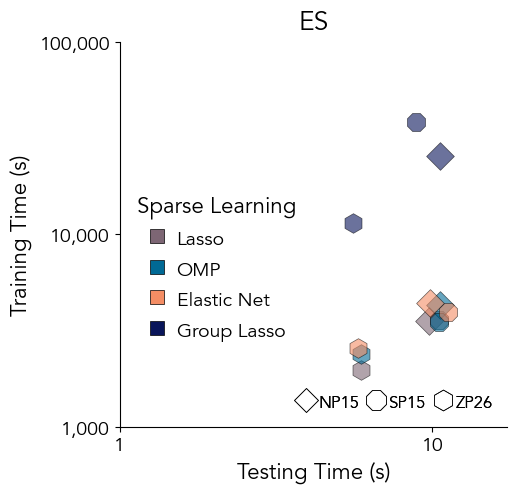

In [16]:
_plot_computing_time(time_, score    = 'ES', 
                            colors_  = colors_1_, 
                            suptitle = '', 
                            title    = 'ES', 
                            save     = True, 
                            legend   = True, 
                            x_max    = 20,
                            path     = path_to_images, 
                            filename = 'ms_computing_time_ES.png')

# Model Selection

In [17]:
# def _force_zero(x_):
#     x_[x_ < 0.] = 0.
#     return x_

# def _plot_confidence_intervals(_model, _baselines, meta_, zones_, i_zone, i_sel_sample, i_resource, y_min     = 0.,
#                                                                                         y_max     = 0., 
#                                                                                         x_mark    = -1.,
#                                                                                         legend    = True, 
#                                                                                         path      = '',
#                                                                                         linestyle = '-',
#                                                                                         save      = True, 
#                                                                                         file_name = 'noname.pdf', 
#                                                                                         letter    = '',
#                                                                                         colors_2_ = colors_2_):    
    
#     zone      = zones_[i_zone]
#     z_scores_ = [0.84, 1.28, 1.64, 1.96, 2.24]
#     ci_       = [60, 80, 90, 95, 97.5]
#     colors_   = ['#99A3A4', '#B2BABB', '#CCD1D1', '#E0E0E0', '#E5E8E8']

#     y_       = _model['targets'][i_sel_sample, i_resource, :]
#     mu_      = _model['mean'][i_sel_sample, i_resource, :]
#     s2_      = np.sqrt(_model['variance'][i_sel_sample, i_resource, :])
#     Y_scens_ = _force_zero(_model['samples'][i_sel_sample, i_resource, :, :])

#     y_prs_ = _baselines['persitence'][i_sel_sample, i_zone, :]
#     y_clm_ = _baselines['climatology'][i_sel_sample, i_zone, :]
#     y_iso_ = _baselines['caiso'][i_sel_sample, i_zone, :]

#     if y_min == 0.:
#         y_min = _model['samples'][:, i_resource, :, :].min()
#     if y_max == 0.:
#         y_max = _model['samples'][:, i_resource, :, :].max()

#     x_ = np.linspace(0, y_.shape[0] - 1, y_.shape[0], dtype = int)

#     fig = plt.figure(figsize = (7.5, 3.))
#     ax  = plt.subplot(111)

#     plt.title(f'{zone}', fontsize = 14)

#     ax.plot(x_, _force_zero(y_), color     = 'r', 
#                                  linestyle = linestyle, 
#                                  label     = r'$y$ (ac)',
#                                  lw        = 1.5, 
#                                  alpha     = .75, 
#                                  zorder    = 12)


#     ax.plot(x_, _force_zero(mu_), color     = 'k', 
#                                   linestyle = '-', 
#                                   label     = r'$\mu$ (fc)',
#                                   lw        = .5, 
#                                   alpha     = 1., 
#                                   zorder    = 10)
    
#     ax.plot(x_, y_prs_, color     = colors_2_[0], 
#                         linestyle = ':', 
#                         label     = r'Per. (fc)',
#                         lw        = 2., 
#                         alpha     = 1., 
#                         zorder    = 11)

#     ax.plot(x_, y_clm_, color     = colors_2_[1], 
#                         linestyle = ':', 
#                         label     = r'Cli. (fc)',
#                         lw        = 2., 
#                         alpha     = 1., 
#                         zorder    = 11)

    
#     ax.plot(x_, y_iso_, color     = colors_2_[2], 
#                         linestyle = ':', 
#                         label     = r'CAISO (fc)',
#                         lw        = 2., 
#                         alpha     = 1., 
#                         zorder    = 11)

#     i = 0
#     for z, ci, color in zip(z_scores_, ci_, colors_):
#         ax.fill_between(x_, _force_zero(mu_ + z*s2_), _force_zero(mu_ - z*s2_), color  = color, 
#                                                                                 label  = f'{ci:02}%', 
#                                                                                 alpha  = .75, 
#                                                                                 zorder = 7 - i)
#         i += 1

#     if legend:
#         ax.legend(loc            = 'center', 
#                   bbox_to_anchor = (.5, 0.9),
#                   frameon        = False, 
#                   columnspacing = 0.4, 
#                   handletextpad = .2,
#                   ncol           = 11,
#                   prop           = {'size': 8.5})

#     ax.set_xlabel(r'{}'.format(meta_.loc[i_sel_sample, 'date']), fontsize = 12)
#     ax.set_ylabel(r'Energy (MWh)', fontsize = 12)

#     ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

#     ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

#     plt.xlim(0, 23)

#     ax.grid(axis = 'y')
#     ax.set_xticks(x_, [f'{x}:00' for x in x_.astype(int)], rotation = 45)

#     #ax.xaxis.set_tick_params(labelsize = 10, left = False)
#     ax.yaxis.set_tick_params(labelsize = 10, 
#                              left      = False)

#     plt.ylim(y_min, y_max)

#     ax.text(-2.5, y_max*1.125, letter, fontsize = 20, 
#                                        weight   = "bold")

#     ax.axhline(y_min, linewidth = .5, 
#                       linestyle = '-', 
#                       color     = 'k', 
#                       clip_on   = False, 
#                       zorder    = 10)
        
#     ax.axvline(x_mark, linewidth = .5, 
#                        linestyle = ':', 
#                        color     = 'k', 
#                        clip_on   = False, 
#                        zorder    = 10)

#     if save: plt.savefig(path + file_name.format(zone, i_sel_sample), bbox_inches = 'tight', 
#                                                                       dpi         = 250)

#     plt.show()
    

#     # Evaluate a scenario's predictive probability
# def _eval_proba(_model, Y_scens_, i_sel_sample):
#     mu_      = _model['mean'][i_sel_sample, ...]
#     Sigma_   = _model['covariance'][i_sel_sample, ...]

#     Z_ = np.zeros((Y_scens_.shape[1], Y_scens_.shape[2]))
#     for t in range(mu_.shape[1]):    
#         Z_[t, :] = multivariate_normal(mu_[:, t], Sigma_[..., t]).pdf(Y_scens_[:, t, :].T)
#     z_  = np.prod(Z_, axis = 0)
#     z_ /= z_.sum()
#     return z_

# def _plot_scenarios(_model, meta_, zones_, i_zone, i_resource, i_sel_sample, y_min     = 0.,
#                                                                  y_max     = 0.,
#                                                                  legend    = True, 
#                                                                  path      = '',
#                                                                  x_mark    = -1.,
#                                                                  linestyle = '--',
#                                                                  save      = True, 
#                                                                  file_name = 'noname.pdf', 
#                                                                  letter    = ''):
#     zone = zones_[i_zone]
    
#     y_       = _model['targets'][i_sel_sample, i_resource, :]
#     mu_      = _model['mean'][i_sel_sample, i_resource, :]
#     Y_scens_ = _model['samples'][i_sel_sample, ...]
#     #Y_scens_ = _smooth_gaussian(Y_scens_, sigma = _model['sigma'])
#     z_       = _eval_proba(_model, Y_scens_, i_sel_sample)
#     Y_scens_ = Y_scens_[i_resource, ...]

#     if y_min == 0.:
#         y_min = _model['samples'][:, i_resource, :, :].min()
#     if y_max == 0.:
#         y_max = _model['samples'][:, i_resource, :, :].max()

#     x_ = np.linspace(0, y_.shape[0] - 1, y_.shape[0], dtype = int)

#     fig = plt.figure(figsize = (7.5, 3.))
#     ax  = plt.subplot(111)

#     ax.plot(x_, _force_zero(y_), color     = 'r', 
#                                  linestyle = linestyle, 
#                                  label     = '$y$ (ac)',
#                                  lw        = 1.5, 
#                                  alpha     = .75, 
#                                  zorder    = 11)

#     z_p_ = np.cbrt(np.cbrt(np.cbrt(z_)))
        
#     _cmap = colors.LinearSegmentedColormap.from_list("my_colormap", ["lightgray", "silver", "gray", 'k'])

#     _colormap = cm.ScalarMappable(norm = colors.Normalize(vmin = z_p_.min(), 
#                                                           vmax = z_p_.max()), cmap = _cmap)
#     _colormap.get_clim()

#     for i in np.argsort(z_p_):
        
#         if i == 0:
#             ax.plot(x_, Y_scens_[:, i], color     = 'gray', 
#                                         linestyle = '-', 
#                                         label     = '$y^\star_k$ (sc)',
#                                         lw        = 1., 
#                                         alpha     = 1., 
#                                         zorder    = 10)
            
#         ax.plot(x_, Y_scens_[:, i], color     = _colormap.to_rgba(z_p_[i]), 
#                                     linestyle = '-', 
#                                     lw        = 1., 
#                                     alpha     = .5, 
#                                     zorder    = 10)

#     if legend:
#         ax.legend(loc            = 'center', 
#                   bbox_to_anchor = (.85, 0.82),
#                   frameon        = False, 
#                   columnspacing = 0.5, 
#                   handletextpad = .25,
#                   ncol           = 2,
#                   prop           = {'size': 10})
        
#     ax.set_xlabel(r'{}'.format(meta_.loc[i_sel_sample, 'date']), fontsize = 12)
#     ax.set_ylabel(r'Energy (MWh)', fontsize = 12)

#     ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

#     ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

#     plt.xlim(0, 23)

#     ax.grid(axis = 'y')
#     ax.set_xticks(x_, [f'{x}:00' for x in x_.astype(int)], rotation = 45)

#     ax.yaxis.set_tick_params(labelsize = 10, left = False)
    
#     plt.ylim(y_min, y_max)

#     ax.text(-2.5, y_max*1.25, letter, fontsize = 20, 
#                                       weight   = "bold")

#     ax.axhline(y_min, linewidth = .5, 
#                       linestyle = '-', 
#                       color     = 'k', 
#                       clip_on   = False, 
#                       zorder    = 10)
    
#     ax.axvline(x_mark, linewidth = .5, 
#                        linestyle = ':', 
#                        color     = 'k', 
#                        clip_on   = False, 
#                        zorder    = 10)

#     fig.colorbar(_colormap, orientation = "horizontal", 
#                             cax         = fig.add_axes([0.165, 0.72, 0.15, 0.05])  ,
#                             ticks       = [],
#                             extend      = 'max').set_label(r'$Pr(y^\star_k | \hat{\theta}, X^\star)$', 
#                                                            rotation = 0, 
#                                                            size     = 10)

#     if save: plt.savefig(path + file_name.format(zones_[i_zone], i_sel_sample), bbox_inches = 'tight', 
#                                                                                 dpi         = 250)


#     plt.show()
    
    
# def _plot_multisource_density_detail(_model, meta_, i_sel_sample_1, i_sel_sample_2, i_resource, 
#                                      x_mark    = 0,
#                                      legend    = True, 
#                                      y_min     = 0,
#                                      y_max     = 25000.,
#                                      path      = '',
#                                      save      = True, 
#                                      file_name = 'noname.pdf', 
#                                      letter    = ''):
    
#     i_hour = x_mark
    
#     y_1        = _model['targets'][i_sel_sample_1, i_resource, i_hour]
#     mu_1       = _model['mean'][i_sel_sample_1, i_resource, i_hour]
#     s2_1       = np.sqrt(_model['variance'][i_sel_sample_1, i_resource, i_hour])
#     Y_scens_1_ = _model['samples'][i_sel_sample_1, ...]
    
#     y_2        = _model['targets'][i_sel_sample_2, i_resource, i_hour]
#     mu_2       = _model['mean'][i_sel_sample_2, i_resource, i_hour]
#     s2_2       = np.sqrt(_model['variance'][i_sel_sample_2, i_resource, i_hour])
#     Y_scens_2_ = _model['samples'][i_sel_sample_2, ...]
    
#     _N_1 = stats.norm(mu_1, s2_1)
#     _N_2 = stats.norm(mu_2, s2_2)
    
#     y_ = np.linspace(0., y_max, 1000)

#     fig = plt.figure(figsize = (3., 3.))
#     ax  = plt.subplot(111)

#     plt.title(r'{}:00'.format(i_hour), fontsize = 14)

#     ax.axhline(y_1, linewidth = 1., 
#                     label     = r'y (ac) - {}'.format(meta_.loc[i_sel_sample_1, 'date']), 
#                     linestyle = '-', 
#                     color     = 'r', 
#                     clip_on   = False, 
#                     zorder    = 15)
    
#     ax.plot(_N_1.pdf(y_), y_, color     = 'k', 
#                               linestyle = '-', 
#                               lw        = .25, 
#                               alpha     = .5, 
#                               zorder    = 13)
    
#     ax.axhline(y_2, linewidth = 1., 
#                     label     = r'y (ac) - {}'.format(meta_.loc[i_sel_sample_2, 'date']),
#                     linestyle = '--', 
#                     color     = 'r', 
#                     clip_on   = False, 
#                     zorder    = 15)

#     ax.plot(_N_2.pdf(y_), y_, color     = 'k', 
#                               linestyle = '--', 
#                               lw        = .25, 
#                               alpha     = .5, 
#                               zorder    = 7)
    
#     z_scores_ = [0.67, 1.15, 1.64, 1.96, 2.17, 2.32, np.inf]
#     ci_       = [50, 75, 90, 95, 97, 98, 100]
#     colors_   = ['#707B7C', '#99A3A4', '#B2BABB', '#CCD1D1', '#E5E8E8', '#F2F4F4', 'w']
    
#     i = 0
#     for z, ci, color in zip(z_scores_, ci_, colors_):
    
#         ax.fill_betweenx(y_, _N_1.pdf(y_), where       = (y_ < mu_1 + z*s2_1) & (y_ > mu_1 - z*s2_1), 
#                                            color       = color, 
#                                            alpha       = .75, 
#                                            zorder      = 12 - i,
#                                            interpolate = True)
        
#         ax.fill_betweenx(y_, _N_2.pdf(y_), where       = (y_ < mu_2 + z*s2_2) & (y_ > mu_2 - z*s2_2), 
#                                            color       = color, 
#                                            alpha       = .75, 
#                                            zorder      = 6 - i,
#                                            interpolate = True)
        
#         i += 1

#     if legend:
#         ax.legend(frameon = False,
#                   prop    = {'size': 10})
        
#     ax.set_xlabel(r'$p\left(y^\star_t\right)$', fontsize = 12)
#     ax.set_ylabel(r'Energy (MWh)', fontsize = 12)

#     ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

#     ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

#     ax.grid(axis = 'y')

#     ax.yaxis.set_tick_params(labelsize = 10, left = False)

#     plt.ylim(-15., y_max)
#     plt.xlim(0., )

#     ax.text(-0.0002, y_max*1.05, letter, fontsize = 20, 
#                                       weight   = "bold")

#     # ax.text(0., y_max*1.25, scen_lable, fontsize = 16)

#     ax.axhline(y_min, linewidth = .5, 
#                       linestyle = '-', 
#                       color     = 'k', 
#                       clip_on   = False, 
#                       zorder    = 10)

#     ax.axvline(0, linewidth = .5, 
#                   linestyle = '-', 
#                   color     = 'k', 
#                   clip_on   = False, 
#                   zorder    = 10)


#     if save: plt.savefig(path + file_name.format(i_sel_sample_1, i_sel_sample_2), 
#                          bbox_inches = 'tight', 
#                          dpi         = 300)


#     plt.show()
    
# def _plot_multisource_hist_detail(_model, meta_, i_sel_sample_1, i_sel_sample_2, i_resource, 
#                                   x_mark    = 0,
#                                   nbins     = 100,
#                                   legend    = True, 
#                                   y_min     = 0,
#                                   y_max     = 25000.,
#                                   path      = '',
#                                   save      = True, 
#                                   file_name = 'noname.pdf', 
#                                   letter    = ''):
    
#     i_hour = x_mark
    
#     y_1        = _model['targets'][i_sel_sample_1, i_resource, i_hour]
#     mu_1       = _model['mean'][i_sel_sample_1, i_resource, i_hour]
#     s2_1       = np.sqrt(_model['variance'][i_sel_sample_1, i_resource, i_hour])
#     Y_scens_1_ = _model['samples'][i_sel_sample_1, i_resource, i_hour, :]
    
#     y_2        = _model['targets'][i_sel_sample_2, i_resource, i_hour]
#     mu_2       = _model['mean'][i_sel_sample_2, i_resource, i_hour]
#     s2_2       = np.sqrt(_model['variance'][i_sel_sample_2, i_resource, i_hour])
#     Y_scens_2_ = _model['samples'][i_sel_sample_2, i_resource, i_hour, :]

#     _N_1 = stats.norm(mu_1, s2_1)
#     _N_2 = stats.norm(mu_2, s2_2)
    
#     y_ = np.linspace(0., y_max, 1000)

#     fig = plt.figure(figsize = (3., 3.))
#     ax  = plt.subplot(111)

#     plt.title(r'{}:00'.format(i_hour), fontsize = 14)

#     ax.axhline(y_1, linewidth = 1., 
#                     label     = r'y (ac) - {}'.format(meta_.loc[i_sel_sample_1, 'date']), 
#                     linestyle = '-', 
#                     color     = 'r', 
#                     clip_on   = False, 
#                     zorder    = 15)
    
#     ax.plot(_N_1.pdf(y_), y_, color     = 'k', 
#                               linestyle = '-', 
#                               lw        = .25, 
#                               alpha     = .75, 
#                               zorder    = 13)
    
#     ax.hist(Y_scens_1_, bins        = nbins, 
#                         range       = (-15., y_max),
#                         color       = '#707B7C', 
#                         orientation = "horizontal", 
#                         zorder      = 1, 
#                         alpha       = 0.75, 
#                         density     = True, 
#                         edgecolor   ='k', 
#                         linewidth   = .25)
    
#     ax.axhline(y_2, linewidth = 1., 
#                     label     = r'y (ac) - {}'.format(meta_.loc[i_sel_sample_2, 'date']),
#                     linestyle = '--', 
#                     color     = 'r', 
#                     clip_on   = False, 
#                     zorder    = 15)

#     ax.plot(_N_2.pdf(y_), y_, color     = 'k', 
#                               linestyle = '--', 
#                               lw        = .25, 
#                               alpha     = .75, 
#                               zorder    = 7)

#     ax.hist(Y_scens_2_, bins        = nbins, 
#                         range       = (-15., y_max), 
#                         color       = '#707B7C', 
#                         orientation = "horizontal", 
#                         zorder      = 1, 
#                         alpha       = 0.75, 
#                         density     = True, 
#                         edgecolor   ='k', 
#                         linewidth   = .25)

#     z_scores_ = [0.67, 1.15, 1.64, 1.96, 2.17, 2.32, np.inf]
#     ci_       = [50, 75, 90, 95, 97, 98, 100]
#     colors_   = ['#707B7C', '#99A3A4', '#B2BABB', '#CCD1D1', '#E5E8E8', '#F2F4F4', 'w']

#     if legend:
#         ax.legend(frameon = False,
#                   prop    = {'size': 10})
        
#     ax.set_xlabel(r'$p\left(y^\star_t\right)$', fontsize = 12)
#     ax.set_ylabel(r'Energy (MWh)', fontsize = 12)

#     ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

#     ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)


#     ax.grid(axis = 'y')

#     ax.yaxis.set_tick_params(labelsize = 10, left = False)

#     plt.ylim(-15., y_max)
#     plt.xlim(0., )

#     ax.text(-0.0002, y_max*1.05, letter, fontsize = 20, 
#                                       weight   = "bold")

#     # ax.text(0., y_max*1.25, scen_lable, fontsize = 16)

#     ax.axhline(y_min, linewidth = .5, 
#                       linestyle = '-', 
#                       color     = 'k', 
#                       clip_on   = False, 
#                       zorder    = 10)

#     ax.axvline(0, linewidth = .5, 
#                   linestyle = '-', 
#                   color     = 'k', 
#                   clip_on   = False, 
#                   zorder    = 10)


#     if save: plt.savefig(path + file_name.format(i_sel_sample_1, i_sel_sample_2),
#                          bbox_inches = 'tight', 
#                          dpi         = 300)


#     plt.show()
    

# def _load_model_data(model_name, path):
    
#     _model = pd.read_pickle(path + model_name)
    
#     meta_         = _model['targets_meta']
#     meta_['date'] = pd.to_datetime(meta_[["year", "month", "day"]])
#     meta_['date'] = meta_['date'].dt.strftime('%m/%d/%Y')
    
#     return _model, meta_


# Model Selection

In [18]:
# l_baselines_file_name = 'load-1-2-3_baselines.pkl'
# s_baselines_file_name = 'solar-0-1-2_baselines.pkl'
# w_baselines_file_name = 'wind-0-1_baselines.pkl'

# _l_baselines = pd.read_pickle(path_to_prc + l_baselines_file_name)
# _s_baselines = pd.read_pickle(path_to_prc + s_baselines_file_name)
# _w_baselines = pd.read_pickle(path_to_prc + w_baselines_file_name)

# #path_to_mdls    = r'/Users/Guille/Desktop/caiso_power/models/journal_paper_w_sigma_n_lambda-Cal/'
# path_to_mdls    = r'/Users/Guille/Desktop/caiso_power/models/journal_paper_w_sigma_n_lambda-Cal-2/'
# #path_to_mdls    = r'/Users/Guille/Desktop/caiso_power/models/journal_paper_w_sigma_n_lambda-NoCal/'

### NP15 Model

In [130]:
# #multiresource_model_name = 'NP15-lasso-MTGPR-LogS.pkl'
# multiresource_model_name = 'NP15-lasso-MTGPR-ES.pkl'
# #multiresource_model_name = 'NP15-lasso-MTGPR-LogS.pkl'

# _model_1, meta_1_ = _load_model_data(model_name = multiresource_model_name, path = path_to_mdls)

### SP15 Model

In [129]:
# multiresource_model_name = 'SP15-elastic_net-MTGPR-ES.pkl'
# #multiresource_model_name = 'SP15-OMP-MTGPR-VS.pkl'
# #multiresource_model_name = 'SP15-lasso-MTGPR-LogS.pkl'

# _model_2, meta_2_ = _load_model_data(model_name = multiresource_model_name, path = path_to_mdls)

### ZP26 Model

In [128]:
# multiresource_model_name = 'ZP26-elastic_net-MTGPR-ES.pkl'
# #multiresource_model_name = 'ZP26-OMP-MTGPR-VS.pkl'
# #multiresource_model_name = 'ZP26-lasso-MTGPR-LogS.pkl'

# _model_3, meta_3_ = _load_model_data(model_name = multiresource_model_name, path = path_to_mdls)

### Load Forecasting Example

In [127]:
# x_mark     = 18
# i_resource = 0
# i_zone     = 1

# meta_  = [meta_1_, meta_2_, meta_3_][i_zone]
# _model = [_model_1, _model_2, _model_3][i_zone]

# s2_          = np.sqrt(_model['variance'][:, i_resource, x_mark])
# i_min_sample = np.argsort(s2_)[5]
# i_max_sample = np.argsort(s2_)[::-1][24]
# print(i_max_sample, i_min_sample, s2_[i_max_sample], s2_[i_min_sample], s2_[i_max_sample]/s2_[i_min_sample])

In [57]:
# x_mark     = 18
# i_resource = 0
# i_zone     = 0

# meta_  = [meta_1_, meta_2_, meta_3_][i_zone]
# _model = [_model_1, _model_2, _model_3][i_zone]

# print(_model.keys())

# y_  = _model['targets'][:, i_resource, :]
# s2_ = np.sqrt(_model['variance'][:, i_resource, :])
# mu_ = _model['mean'][:, i_resource, :]

# print(y_.shape, mu_.shape, s2_.shape)
# z = 2.
# ci_ = []
# #for i_hour in range(24):
# for i_hour in range(10, 14, 1):
#     idx_ = (y_[:, i_hour] <= (mu_[:, i_hour] + z*s2_[:, i_hour])) & (y_[:, i_hour] >= (mu_[:, i_hour] - z*s2_[:, i_hour]))
#     N_samples = 100.*idx_.sum()/mu_.shape[0]
#     ci_.append(N_samples)
# print(np.mean(ci_))

In [58]:
# x_mark     = 18
# i_resource = 0
# i_zone     = 0

# meta_  = [meta_1_, meta_2_, meta_3_][i_zone]
# _model = [_model_1, _model_2, _model_3][i_zone]

# zones_ = ['NP15', 'SP15', 'ZP26']

# for i in range(0, 240, 10):
#     print(i)

#     _plot_confidence_intervals(_model, _l_baselines, meta_, zones_, 
#                                i_zone       = i_zone, 
#                                i_sel_sample = i, 
#                                x_mark       = x_mark,
#                                y_min        = -1.,
#                                y_max        = 20000,
#                                i_resource   = i_resource, 
#                                legend       = True, 
#                                path         = path_to_images,
#                                save         = True, 
#                                linestyle    = '--',
#                                file_name    = 'ci_load_{}-{}.png')


In [58]:
# _plot_confidence_intervals(_model, _l_baselines, meta_, zones_, 
#                            i_zone       = i_zone, 
#                            i_sel_sample = i_min_sample, 
#                            x_mark       = x_mark,
#                            y_min        = -100.,
#                            y_max        = 25000,
#                            i_resource   = i_resource, 
#                            legend       = True, 
#                            path         = path_to_images,
#                            save         = True, 
#                            linestyle    = '-',
#                            file_name    = 'multisource_ci_load_{}-{}.png')

# _plot_confidence_intervals(_model, _l_baselines, meta_, zones_, 
#                            i_zone       = i_zone,
#                            i_sel_sample = i_max_sample, 
#                            x_mark       = x_mark,
#                            y_min        = -1.,
#                            y_max        = 25000,
#                            i_resource   = i_resource, 
#                            legend       = True, 
#                            path         = path_to_images,
#                            save         = True, 
#                            linestyle    = '--',
#                            file_name    = 'multisource_ci_load_{}-{}.png')

In [59]:
# _plot_scenarios(_model, meta_, zones_, 
#                 i_sel_sample = i_min_sample, 
#                 i_resource   = i_resource, 
#                 i_zone       = i_zone, 
#                 x_mark       = x_mark,
#                 y_min        = -1.,
#                 y_max        = 20000,
#                 legend       = False, 
#                 save         = True, 
#                 linestyle    = '-',
#                 path         = path_to_images,
#                 file_name    = 'multisource_scen_load_{}-{}.png')

# _plot_scenarios(_model, meta_, zones_, 
#                 i_sel_sample = i_max_sample, 
#                 i_resource   = i_resource, 
#                 i_zone       = i_zone, 
#                 x_mark       = x_mark,
#                 y_min        = -1.,
#                 y_max        = 20000,
#                 legend       = False, 
#                 save         = True, 
#                 linestyle    = '--',
#                 path         = path_to_images,
#                 file_name    = 'multisource_scen_load_{}-{}.png')

In [56]:
# _plot_multisource_density_detail(_model, meta_, i_min_sample, i_max_sample, 
#                                  i_resource = i_resource, 
#                                  x_mark     = x_mark,
#                                  y_min      = -1.,
#                                  y_max      = 25000,
#                                  legend     = True, 
#                                  save       = True, 
#                                  path       = path_to_images,
#                                  file_name  = 'multisource_ci_detail_load_{}-{}.png')
    

# _plot_multisource_hist_detail(_model, meta_, i_min_sample, i_max_sample, 
#                               i_resource = i_resource, 
#                               x_mark     = x_mark,
#                               y_min      = -1.,
#                               y_max      = 25000,
#                               legend     = True, 
#                               save       = True, 
#                               nbins      = 40,
#                               path       = path_to_images,
#                               file_name  = 'multisource_hist_detail_load_{}-{}.png')

### Solar Forecasting Example

In [60]:
# x_mark     = 17
# i_resource = 1
# i_zone     = 1

# meta_  = [meta_1_, meta_2_, meta_3_][i_zone]
# _model = [_model_1, _model_2, _model_3][i_zone]

# s2_          = np.sqrt(_model['variance'][:, i_resource, x_mark])
# i_min_sample = np.argsort(s2_)[8]
# i_max_sample = np.argsort(s2_)[::-1][9]
# print(i_max_sample, i_min_sample, s2_[i_max_sample], s2_[i_min_sample], s2_[i_max_sample]/s2_[i_min_sample])

In [61]:
# _plot_confidence_intervals(_model, _s_baselines, meta_, zones_, 
#                            i_zone       = i_zone, 
#                            i_sel_sample = i_min_sample, 
#                            x_mark       = x_mark,
#                            y_min        = -1.,
#                            y_max        = 12500,
#                            i_resource   = i_resource, 
#                            legend       = True, 
#                            path         = path_to_images,
#                            save         = True, 
#                            linestyle    = '--',
#                            file_name    = 'multisource_ci_solar_{}-{}.png')

# _plot_confidence_intervals(_model, _s_baselines, meta_, zones_, 
#                            i_zone       = i_zone,
#                            i_sel_sample = i_max_sample, 
#                            x_mark       = x_mark,
#                            y_min        = -1.,
#                            y_max        = 12500,
#                            i_resource   = i_resource, 
#                            legend       = True, 
#                            path         = path_to_images,
#                            save         = True, 
#                            linestyle    = '-',
#                            file_name    = 'multisource_ci_solar_{}-{}.png')

In [63]:
# _plot_scenarios(_model, meta_, zones_, 
#                 i_sel_sample = i_min_sample, 
#                 i_resource   = i_resource, 
#                 i_zone       = i_zone, 
#                 x_mark       = x_mark,
#                 y_min        = -1.,
#                 y_max        = 12500,
#                 legend       = False, 
#                 save         = True, 
#                 linestyle    = '--',
#                 path         = path_to_images,
#                 file_name    = 'multisource_scen_solar_{}-{}.png')

# _plot_scenarios(_model, meta_, zones_, 
#                 i_sel_sample = i_max_sample, 
#                 i_resource   = i_resource, 
#                 i_zone       = i_zone, 
#                 x_mark       = x_mark,
#                 y_min        = -1.,
#                 # y_max        = 12500,
#                 legend       = False, 
#                 save         = True, 
#                 linestyle    = '-',
#                 path         = path_to_images,
#                 file_name    = 'multisource_scen_solar_{}-{}.png')

In [64]:
# _plot_multisource_density_detail(_model, meta_, i_min_sample, i_max_sample, 
#                                  i_resource = i_resource, 
#                                  x_mark     = x_mark,
#                                  y_min      = -1.,
#                                  y_max      = 12500,
#                                  legend     = True, 
#                                  save       = True, 
#                                  path       = path_to_images,
#                                  file_name  = 'multisource_ci_detail_solar_{}-{}.png')
    

# _plot_multisource_hist_detail(_model, meta_, i_min_sample, i_max_sample, 
#                               i_resource = i_resource, 
#                               x_mark     = x_mark,
#                               y_min      = -1.,
#                               y_max      = 12500,
#                               legend     = True, 
#                               save       = True, 
#                               nbins      = 30,
#                               path       = path_to_images,
#                               file_name  = 'multisource_hist_detail_solar_{}-{}.png')

### Wind Forecasting Example

In [126]:
# x_mark     = 21
# i_resource = 2
# i_zone     = 1

# meta_  = [meta_1_, meta_2_, meta_3_][i_zone]
# _model = [_model_1, _model_2, _model_3][i_zone]

# s2_          = np.sqrt(_model['variance'][:, i_resource, x_mark])
# i_min_sample = np.argsort(s2_)[16]
# i_max_sample = np.argsort(s2_)[::-1][3]
# print(i_max_sample, i_min_sample, s2_[i_max_sample], s2_[i_min_sample], s2_[i_max_sample]/s2_[i_min_sample])

In [67]:
# x_mark     = 18
# i_resource = 2
# i_zone     = 1

# meta_  = [meta_1_, meta_2_, meta_3_][i_zone]
# _model = [_model_1, _model_2, _model_3][i_zone]

# for i in range(0, 240, 10):
#     print(i)
#     _plot_confidence_intervals(_model, _w_baselines, meta_, zones_, 
#                                i_zone       = i_zone, 
#                                i_resource   = i_resource, 
#                                i_sel_sample = i, 
#                                x_mark       = x_mark,
#                                y_min        = -1.,
#                                y_max        = 5000,
#                                legend       = True, 
#                                path         = path_to_images,
#                                save         = True, 
#                                linestyle    = '--',
#                                file_name    = 'ci_wind_{}-{}.png')

In [65]:
# _plot_confidence_intervals(_model, _w_baselines, meta_, zones_, 
#                            i_zone       = i_zone, 
#                            i_resource   = i_resource, 
#                            i_sel_sample = i_min_sample, 
#                            x_mark       = x_mark,
#                            y_min        = -1.,
#                            y_max        = 5000,
#                            legend       = True, 
#                            path         = path_to_images,
#                            save         = True, 
#                            linestyle    = '--',
#                            file_name    = 'multisource_ci_wind_{}-{}.png')

# _plot_confidence_intervals(_model, _w_baselines, meta_, zones_, 
#                            i_zone       = i_zone,
#                            i_resource   = i_resource, 
#                            i_sel_sample = i_max_sample, 
#                            x_mark       = x_mark,
#                            y_min        = -1.,
#                            y_max        = 5000,
#                            legend       = True, 
#                            path         = path_to_images,
#                            save         = True, 
#                            linestyle    = '-',
#                            file_name    = 'multisource_ci_wind_{}-{}.png')

In [66]:
# _plot_scenarios(_model, meta_, zones_, i_resource   = i_resource, 
#                                        i_sel_sample = i_min_sample,   
#                                        i_zone       = i_zone, 
#                                        x_mark       = x_mark,
#                                        y_min        = -1.,
#                                        y_max        = 5000,
#                                        legend       = True, 
#                                        save         = True, 
#                                        linestyle    = '--',
#                                        path         = path_to_images,
#                                        file_name    = 'multisource_scen_wind_{}-{}.png')

# _plot_scenarios(_model, meta_, zones_, i_sel_sample = i_max_sample, 
#                                        i_resource   = i_resource, 
#                                        i_zone       = i_zone, 
#                                        x_mark       = x_mark,
#                                        y_min        = -1.,
#                                        y_max        = 5000,
#                                        legend       = False, 
#                                        save         = True, 
#                                        linestyle    = '-',
#                                        path         = path_to_images,
#                                        file_name    = 'multisource_scen_wind_{}-{}.png')

In [67]:
# _plot_multisource_density_detail(_model, meta_, i_min_sample, i_max_sample, 
#                                  i_resource = i_resource, 
#                                  x_mark     = x_mark,
#                                  y_min      = -1.,
#                                  y_max      = 5000,
#                                  legend     = True, 
#                                  save       = True, 
#                                  path       = path_to_images,
#                                  file_name  = 'multisource_ci_detail_wind_{}-{}.png')
    

# _plot_multisource_hist_detail(_model, meta_, i_min_sample, i_max_sample, 
#                               i_resource = i_resource, 
#                               x_mark     = x_mark,
#                               y_min      = -1.,
#                               y_max      = 5000,
#                               legend     = True, 
#                               save       = True, 
#                               nbins      = 40,
#                               path       = path_to_images,
#                               file_name  = 'multisource_hist_detail_wind_{}-{}.png')

In [68]:
# from scipy.stats import pearsonr

# i_sel_sample = 100

# # y_1        = _model['targets'][i_sel_sample, i_zone, :]
# # mu_1       = _model['mean'][i_sel_sample, i_zone, i_hour]
# # s2_1       = np.sqrt(_model['variance'][i_sel_sample, i_zone, :])
# Y_scens_ = _model['samples'][i_sel_sample, :, :, :]

# AUC_ = np.sum(_model['samples'][i_sel_sample, 0, :, :], axis = 0)
# idx_AUC_ = np.argsort(AUC_)
# print(AUC_.shape, Y_scens_.shape)

# corr_ = []
# j = 15
# for i in range(243):
#     corr, _ = pearsonr(_model['samples'][i, 0, j, :], 
#                        _model['samples'][i, 2, j, :])
#     corr_.append(corr)
# print(np.mean(corr_))
    
# # for i in range(0, 99, 5):
# #     plt.figure(figsize = (15, 2.5))
# #     plt.subplot(131)
# #     plt.plot(_model['samples'][i_sel_sample, 0, :, :], 'k')
# #     plt.plot(_model['samples'][i_sel_sample, 0, :, idx_AUC_[i]], 'r')
# #     plt.subplot(132)
# #     plt.plot(_model['samples'][i_sel_sample, 1, :, :], 'k')
# #     plt.plot(_model['samples'][i_sel_sample, 1, :, idx_AUC_[i]], 'r')
# #     plt.subplot(133)
# #     plt.plot(_model['samples'][i_sel_sample, 2, :, :], 'k')
# #     plt.plot(_model['samples'][i_sel_sample, 2, :, idx_AUC_[i]], 'r')
# #     plt.show()
    
# #     print(_model['samples'][i_sel_sample, 0, 12, idx_AUC_[i]].shape)



# Sparse Learning Feature Selection

In [12]:
# def _load_model_data(model_name, path):
    
#     _model = pd.read_pickle(path + model_name)
    
#     meta_         = _model['targets_meta']
#     meta_['date'] = pd.to_datetime(meta_[["year", "month", "day"]])
#     meta_['date'] = meta_['date'].dt.strftime('%m/%d/%Y')
    
#     return _model, meta_

# # Loading spatial masks
# def _load_spatial_masks(i_resources_, path, map_file_name   = r"USland_0.125_(-125,-112)_(32,43).pkl",
#                                             masks_file_name = r"density_grid_0.125_(-125,-112)_(32,43).pkl"):
#     # Load the index of US land in the NOAA operational forecast
#     US_land_ = pd.read_pickle(path + map_file_name)
#     # Load the index of Demand, Solar, and Wind land in the NOAA operational forecast
#     D_den_, S_den_, W_den_ = pd.read_pickle(path + masks_file_name)
#     # Define spatial feature masks
#     F_ = np.zeros(US_land_.shape)
#     for i_resource in i_resources_:
#         F_ += [D_den_, S_den_, W_den_][i_resource]
#     return [np.ones(US_land_.shape), US_land_, D_den_ + S_den_ + W_den_, F_]

# def _consistency_and_importance_maps(_model, M_, i_zone, tau = 0.):

#     # Get Grid Dimensions
#     N = 104
#     M = 88

#     N_features_ = [11, 11, 7]
#     N_features  = N_features_[i_zone]

#     mask_  = M_[3]
#     W_hat_ = _model['weights']
#     idx_   = M_[3] > 0
#     N_grid = idx_.sum()
#     print(mask_.shape, W_hat_.shape, N_grid)

#     b_ = np.stack(W_hat_[i*N_grid:(i + 1)*N_grid] for i in range(N_features))
#     B_ = np.sum(np.sqrt(b_**2), -1)
#     print(b_.shape, B_.shape)  

#     features_ = np.zeros((N*M, N_features))
#     for i in range(N_features):
#         features_[idx_, i] = B_[i, :]

#     features_[features_ < tau] = 0
    
#     consistency_map_ = np.sum(features_ > 0., axis = 1)
    
#     importance_map_ = np.sum(features_ , axis = 1)
#     #importance_map_ = importance_map_/importance_map_.sum()
#     features_ = features_/features_.sum()

#     return features_, consistency_map_, importance_map_

# def _plot_feature_map(_world, _US, _CAISO, features_, consistency_map_, W_ref_, i_zone,
#                       c_max    = 4., 
#                       suptitle = '',
#                       beta     = 5e-5,
#                       save     = False, 
#                       legend   = False, 
#                       title    = '',
#                       path     = '', 
#                       filename = 'unnamed.pdf'):

#     labels_ = ['Atmospheric Pressure', 'Direct Irradiance', 'Diffuse Irradiance', 
#                'Dew Point', 'Relative Humidity', 'Temperature',
#                'Wind Speed (10m)', 'Wind Speed (60m)', 'Wind Speed (80m)', 
#                'Wind Speed (100m)', 'Wind Speed (120m)', 'Discomfort Index', 
#                'Wind Chill', 'Heating and Cooling Degree Hours', 'Clear-Sky Irradiance']

#     colors_ = ['#c94f39', '#daac77', '#daac77', 
#                '#c94f39', '#c94f39', '#c94f39', 
#                '#8dc0cd', '#8dc0cd', '#8dc0cd', 
#                '#8dc0cd', '#8dc0cd', '#6ba661', 
#                '#6ba661', '#6ba661', '#daac77']
    
#     x_0 = -124.5
#     x_1 = -112.5
#     y_0 = 32.25
#     y_1 = 42.25

#     fig, ax = plt.subplots(1, 1, figsize = (7.5, 5), 
#                                  squeeze = True)

#     ax = plt.subplot(1, 1, 1) 

#     plt.suptitle(suptitle, fontsize   = 30, 
#                            fontweight = "bold", 
#                            y          = 1.04)
    
#     plt.title(title, fontsize   = 22, 
#                      fontweight = "bold")

#     idx_features_ = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#     map_features_ = [[1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 14], [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 14], [1, 2, 3, 4, 5, 11, 14]][i_zone]
    
#     for i in idx_features_:

#         idx_    = features_[:, i] > 0.001
#         feature = labels_[map_features_[i]]
#         color   = colors_[map_features_[i]]

#         if features_[idx_, i].shape[0] > 0.:
#             ax.scatter(W_ref_[idx_, 0], W_ref_[idx_, 1], marker     = 'o', 
#                                                          s          = 5.*(features_[idx_, i]/beta)**2, 
#                                                          facecolor  = 'None', 
#                                                          edgecolors = color, 
#                                                          lw         = .75,
#                                                          linestyle  = '-',
#                                                          zorder     = 10, 
#                                                          alpha      = 1., clip_on = True) 

#     idx_ = consistency_map_ > 0.
    
#     #_cmap   = mpl.colors.LinearSegmentedColormap.from_list("", ["red", "violet", "blue"])
#     _cmap   = "plasma"
#     _norm   = mpl.colors.Normalize(vmin = 1, vmax = c_max)    
#     _mapper = cm.ScalarMappable(norm = _norm, cmap = _cmap)
    
#     #if legend:
#     cbar    = plt.colorbar(_mapper, cax = fig.add_axes([0.3, 0.2, 0.02, 0.125]), extend = 'max',)
#     cbar.ax.set_ylabel('Consistency', rotation = 270, labelpad = 12.5)

#     ax.scatter(W_ref_[idx_, 0], W_ref_[idx_, 1], marker     = 's', 
#                                                  s          = 13.5, 
#                                                  facecolor  = _mapper.to_rgba(consistency_map_[idx_]),
#                                                  edgecolors = 'None', 
#                                                  zorder     = 5, 
#                                                  alpha      = 1.) 
    
#     _US.to_crs("EPSG:4326").plot(ax        = ax, 
#                                  linewidth = 2., 
#                                  edgecolor = 'none', 
#                                  color     = 'k', 
#                                  alpha     = .4,
#                                  #color     = 'None', 
#                                  zorder    = 2)

#     _US.to_crs("EPSG:4326").plot(ax        = ax, 
#                                  linewidth = 2., 
#                                  edgecolor = 'w', 
#                                  alpha     = 1.,
#                                  color     = 'None', 
#                                  zorder    = 3)
    
#     _CAISO.to_crs("EPSG:4326").plot(ax        = ax, 
#                                     linewidth = .75, 
#                                     edgecolor = 'None', 
#                                     color     = 'k', 
#                                     #color     = 'None', 
#                                     alpha     = .5, 
#                                     zorder    = 2)
    
#     _CAISO.to_crs("EPSG:4326").plot(ax        = ax, 
#                                     linewidth = .75, 
#                                     edgecolor = 'w', 
#                                     color     = 'None', 
#                                     alpha     = 1., 
#                                     zorder    = 3)

#     _world[_world['name'] == 'Mexico'].to_crs("EPSG:4326").plot(ax        = ax, 
#                                                                 linewidth = 5., 
#                                                                 edgecolor = 'None', 
#                                                                 color     = 'k', 
#                                                                 #color     = 'None', 
#                                                                 alpha     = .15, 
#                                                                 zorder    = 1)
    
#     _world[_world['name'] == 'Mexico'].to_crs("EPSG:4326").plot(ax        = ax, 
#                                                                 linewidth = 5., 
#                                                                 edgecolor = 'w', 
#                                                                 color     = 'None', 
#                                                                 alpha     = 1., 
#                                                                 zorder    = 1)
#     if legend:
#         legend_0_ = []
#         for weight, weight_label in zip([1.25, 5., 18, 6.25], [0.5, 1, 2]):
 
#             legend_0_.append(Line2D([0], [0], marker          = 'o', 
#                                               markersize      = weight, 
#                                               markeredgecolor = 'k',
#                                               markeredgewidth = .25,
#                                               color           = "None",
#                                               label           = f'{weight_label}%',
#                                               markerfacecolor = "None"))

#         _leg_0 = ax.legend(handles        = legend_0_, 
#                            title          = r'Importance', 
#                            loc            = 'upper right', 
#                            ncol           = 1, 
#                            bbox_to_anchor = (.675, 1.),
#                            columnspacing  = .225, 
#                            handletextpad  = .5, 
#                            handlelength   = 1.,
#                            frameon        = False, 
#                            fontsize       = 10, 
#                            title_fontsize = 12)

#         ax.add_artist(_leg_0)
        
#         legend_1_ = []
#         for feature_weight, feature_label, color in zip([9., 9., 9., 9.], 
#                                                         ['Solar Radiation', 'Wind Speed', 'Atmospheric', 'Confort'],
#                                                         ['#daac77', '#8dc0cd', '#c94f39', '#6ba661']):
 
#             legend_1_.append(Line2D([0], [0], marker          = 'o', 
#                                               markersize      = feature_weight, 
#                                               markeredgecolor = color,
#                                               markeredgewidth = .5,
#                                               color           = "None",
#                                               label           = '{}'.format(feature_label),
#                                               markerfacecolor = "None"))

#         _leg_1 = ax.legend(handles        = legend_1_, 
#                            title          = r'Feature', 
#                            loc            = 'upper right', 
#                            ncol           = 1, 
#                            bbox_to_anchor = (1., 1.),
#                            columnspacing  = .225, 
#                            handletextpad  = .5, 
#                            handlelength   = 1.,
#                            frameon        = False, 
#                            fontsize       = 10, 
#                            title_fontsize = 12)

#         ax.add_artist(_leg_1)
        
#     ax.set_xlabel('Longitude', fontsize = 14)
#     ax.set_ylabel('Latitude',  fontsize = 14)

#     ax.set_xlim(x_0, x_1)
#     ax.set_ylim(y_0, y_1)

#     ax.axis('off')

#     if save:
#         plt.savefig(path + filename, bbox_inches = 'tight',
#                                      dpi         = 300)
        
#     plt.show()
    
# def _plot_countour_feature_map(_world, _US, _CAISO, importance_map_, consistency_map_, W_ref_, i_zone,
#                                suptitle = '',
#                                beta     = 5e-5,
#                                save     = False, 
#                                legend   = False, 
#                                title    = '',
#                                path     = '', 
#                                filename = 'unnamed.pdf',                            
#                                c_max    = 4):

#     x_0 = -124.5
#     x_1 = -112.5
#     y_0 = 32.25
#     y_1 = 42.25

#     fig, ax = plt.subplots(1, 1, figsize = (7.5, 5), 
#                                  squeeze = True)

#     ax = plt.subplot(1, 1, 1) 

#     plt.suptitle(suptitle, fontsize   = 30, 
#                            fontweight = "bold", 
#                            y          = 1.04)
    
#     plt.title(title, fontsize   = 22, 
#                      fontweight = "bold")

#     _cmap   = "plasma"
#     _norm   = mpl.colors.Normalize(vmin = 1, vmax = c_max)    
#     _mapper = cm.ScalarMappable(norm = _norm, cmap = _cmap)
    
#     idx_    = importance_map_ > 0.001
#     ax.scatter(W_ref_[idx_, 0], W_ref_[idx_, 1], marker     = 'o', 
#                                                  s          = (importance_map_[idx_]/beta)**2, 
#                                                  facecolor  = _mapper.to_rgba(consistency_map_[idx_]), 
#                                                  edgecolors = _mapper.to_rgba(consistency_map_[idx_]), 
#                                                  lw         = .25,
#                                                  linestyle  = '-',
#                                                  zorder     = 10, 
#                                                  alpha      = .5, clip_on = False) 
    

    
#     if legend:
#         cbar    = plt.colorbar(_mapper, cax = fig.add_axes([0.3, 0.2, 0.02,0.125]), extend = 'max',)
#         cbar.ax.set_ylabel('Consistency', rotation = 270, labelpad = 12.5)
    
#     _US.to_crs("EPSG:4326").plot(ax        = ax, 
#                                  linewidth = 2., 
#                                  edgecolor = 'none', 
#                                  color     = 'k', 
#                                  alpha     = .4,
#                                  #color     = 'None', 
#                                  zorder    = 2)

#     _US.to_crs("EPSG:4326").plot(ax        = ax, 
#                                  linewidth = 2., 
#                                  edgecolor = 'w', 
#                                  alpha     = 1.,
#                                  color     = 'None', 
#                                  zorder    = 3)
    
#     _CAISO.to_crs("EPSG:4326").plot(ax        = ax, 
#                                     linewidth = .75, 
#                                     edgecolor = 'None', 
#                                     color     = 'k', 
#                                     #color     = 'None', 
#                                     alpha     = .5, 
#                                     zorder    = 2)
    
#     _CAISO.to_crs("EPSG:4326").plot(ax        = ax, 
#                                     linewidth = .75, 
#                                     edgecolor = 'w', 
#                                     color     = 'None', 
#                                     alpha     = 1., 
#                                     zorder    = 3)

#     _world[_world['name'] == 'Mexico'].to_crs("EPSG:4326").plot(ax        = ax, 
#                                                                 linewidth = 5., 
#                                                                 edgecolor = 'None', 
#                                                                 color     = 'k', 
#                                                                 #color     = 'None', 
#                                                                 alpha     = .15, 
#                                                                 zorder    = 1)
    
#     _world[_world['name'] == 'Mexico'].to_crs("EPSG:4326").plot(ax        = ax, 
#                                                                 linewidth = 5., 
#                                                                 edgecolor = 'w', 
#                                                                 color     = 'None', 
#                                                                 alpha     = 1., 
#                                                                 zorder    = 1)
#     if legend:
#         legend_0_ = []
#         for weight, weight_label in zip([1, 2**2., 4**2, 6.25], [1, 2, 4]):
 
#             legend_0_.append(Line2D([0], [0], marker          = 'o', 
#                                               markersize      = weight, 
#                                               markeredgecolor = 'k',
#                                               markeredgewidth = .25,
#                                               color           = "None",
#                                               label           = f'{weight_label}%',
#                                               markerfacecolor = "None"))

#         _leg_0 = ax.legend(handles        = legend_0_, 
#                            title          = r'Importance', 
#                            loc            = 'upper right', 
#                            ncol           = 1, 
#                            bbox_to_anchor = (.675, 1.),
#                            columnspacing  = .225, 
#                            handletextpad  = .5, 
#                            handlelength   = 1.,
#                            frameon        = False, 
#                            fontsize       = 10, 
#                            title_fontsize = 12)

#         ax.add_artist(_leg_0)
    
#     ax.set_xlabel('Longitude', fontsize = 14)
#     ax.set_ylabel('Latitude',  fontsize = 14)

#     ax.set_xlim(x_0, x_1)
#     ax.set_ylim(y_0, y_1)

#     ax.axis('off')

#     if save:
#         plt.savefig(path + filename, bbox_inches = 'tight',
#                                      dpi         = 300)
        
#     plt.show()
    
    


/var/folders/0c/ffx2kgyn7xq4krqrpsv67l3m0000gn/T/ipykernel_1656/438128410.py:85: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  features_, consistency_map_, importance_map_ = _consistency_and_importance_maps([[_model_1,_model_3], [_model_2, _model_3]][i_zone],


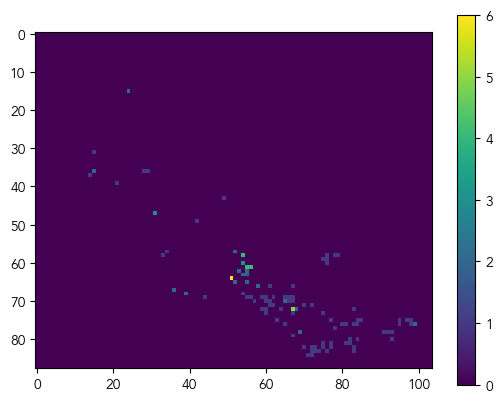

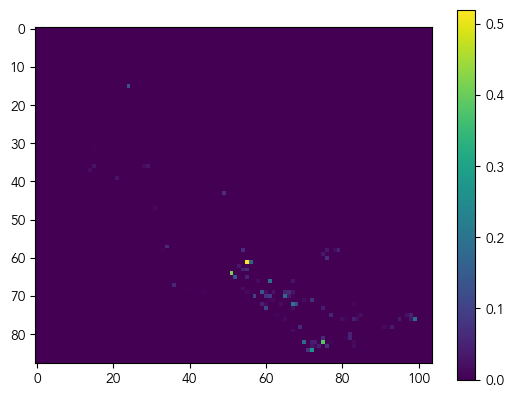

In [131]:
def _load_model_data(model_name, path):
    
    _model = pd.read_pickle(path + model_name)
    
    meta_         = _model['targets_meta']
    meta_['date'] = pd.to_datetime(meta_[["year", "month", "day"]])
    meta_['date'] = meta_['date'].dt.strftime('%m/%d/%Y')
    
    return _model, meta_

# Loading spatial masks
def _load_spatial_masks(i_resources_, path, map_file_name   = r"USland_0.125_(-125,-112)_(32,43).pkl",
                                            masks_file_name = r"density_grid_0.125_(-125,-112)_(32,43).pkl"):
    # Load the index of US land in the NOAA operational forecast
    US_land_ = pd.read_pickle(path + map_file_name)
    # Load the index of Demand, Solar, and Wind land in the NOAA operational forecast
    D_den_, S_den_, W_den_ = pd.read_pickle(path + masks_file_name)
    # Define spatial feature masks
    F_ = np.zeros(US_land_.shape)
    for i_resource in i_resources_:
        F_ += [D_den_, S_den_, W_den_][i_resource]
    return [np.ones(US_land_.shape), US_land_, D_den_ + S_den_ + W_den_, F_]

def _consistency_and_importance_maps(_model, M_, i_zone, tau = 0.):
    
    def __process_weights(W_hat_, mask_, N_features):
        
        W_hat_ = _model_1['weights']
        idx_   = mask_ > 0
        N_grid = idx_.sum()

        b_      = np.stack(W_hat_[i*N_grid:(i + 1)*N_grid] for i in range(N_features))
        b_      = np.sqrt(b_**2)
        b_norm_ = b_.copy()

        for i in range(b_norm_.shape[-1]):
            b_norm_[..., i] = b_norm_[..., i]/b_norm_[..., i].sum()
 
        # Get Grid Dimensions
        N = 104
        M = 88
            
        B_        = np.sum(b_norm_, axis = -1)
        features_ = np.zeros((N*M, N_features))

        for i in range(N_features):
            features_[idx_, i] = B_[i, :]
    
        return features_

    _model_1, _model_2 = _model
    
    features_1_ = __process_weights(_model_1['weights'], M_[2], N_features = 11)
    features_2_ = __process_weights(_model_2['weights'], M_[2], N_features = 7)
    features_   = features_1_.copy()
    
    features_[..., 0]  += features_2_[..., 0]
    features_[..., 1]  += features_2_[..., 1]
    features_[..., 2]  += features_2_[..., 2]
    features_[..., 3]  += features_2_[..., 3]
    features_[..., 4]  += features_2_[..., 4]
    features_[..., 9]  += features_2_[..., 5]
    features_[..., 10] += features_2_[..., 6]
    
    features_[features_ < tau] = 0
    consistency_map_           = np.sum(features_ > 0., axis = 1)
    importance_map_            = np.sum(features_ , axis = 1)
    features_                  = features_/features_.sum()

    return features_, consistency_map_, importance_map_


# Get Grid Dimensions
N = 104
M = 88

zones_   = ['NP15', 'SP15', 'ZP26']
zones_p_ = ['PG&E', 'SCE', 'SDG&E']

_model_1, meta_1_ = _load_model_data('NP15-Elastic_Net-MTGPR-LogS.pkl', path_to_mdls)
_model_2, meta_2_ = _load_model_data('SP15-Elastic_Net-MTGPR-ES.pkl', path_to_mdls)
_model_3, meta_3_ = _load_model_data('ZP26-Elastic_Net-MTGPR-ES.pkl', path_to_mdls)

i_zone = 1
features_, consistency_map_, importance_map_ = _consistency_and_importance_maps([[_model_1,_model_3], [_model_2, _model_3]][i_zone],
                                                                                M_, i_zone, tau = 0.)



In [146]:
def _plot_feature_map(ax, _world, _US, _CAISO, features_, consistency_map_, W_ref_,
                      title = '',
                      c_max    = 4., 
                      beta     = 5e-5,
                      legend   = False):

    labels_ = ['Atmospheric Pressure', 'Shortwave Irradiance', 'Longwave Irradiance', 
               'Dew Point', 'Relative Humidity', 'Temperature',
               'Wind Speed (10m)', 'Wind Speed (60m)', 'Wind Speed (80m)', 
               'Wind Speed (100m)', 'Wind Speed (120m)', 'Discomfort Index', 
               'Wind Chill', 'Heating and Cooling Degree Hours', 'Clear-Sky Irradiance']

    colors_ = ['#FF8989', '#FFE49B', '#FFD053', 
               '#FF4242', '#FF0F0F', '#C80000', 
               '#DBDEFF', '#DBDEFF', '#939DFF', 
               '#4D5EFF', '#0018FF', '#00AF1A', 
               '#6ba661', '#6ba661', '#FFB900']
        
    x_0 = -124.5
    x_1 = -112.5
    y_0 = 32.25
    y_1 = 42.25

    idx_features_ = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    map_features_ = [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 14]
    

    ax.set_title(title, fontsize = 18, y = 1.025, weight = "bold")
    
    for i in range(features_.shape[-1]):

        #idx_    = features_[:, i] > 0.001
        feature = labels_[map_features_[i]]
        color   = colors_[map_features_[i]]
            
        for j in np.argsort(features_[:, i])[::-1]:
            if features_[j, i] > 0.:
                ax.scatter(W_ref_[j, 0], W_ref_[j, 1], marker     = 'o', 
                                                       s          = 7.5*(features_[j, i]/beta)**2, 
                                                       facecolor  = 'None', 
                                                       edgecolors = color, 
                                                       lw         = 1.,
                                                       linestyle  = '-',
                                                       zorder     = 10, 
                                                       alpha      = 1., 
                                                       clip_on    = True) 

    idx_ = consistency_map_ > 0.

    #_cmap   = mpl.colors.LinearSegmentedColormap.from_list("", ["red", "violet", "blue"])
    _cmap   = "plasma"
    _norm   = mpl.colors.Normalize(vmin = 0, vmax = c_max)    
    _mapper = cm.ScalarMappable(norm = _norm, cmap = _cmap)
    
    if legend:
        cbar    = plt.colorbar(_mapper, cax = fig.add_axes([0.6, 0.2, 0.01, 0.1]), ticks = [0, c_max])
        cbar.ax.set_ylabel('Consistency', rotation = 270, 
                                          labelpad = 12.5, 
                                          fontsize = 13)

    ax.scatter(W_ref_[idx_, 0], W_ref_[idx_, 1], marker     = 's', 
                                                 s          = 13.5, 
                                                 facecolor  = _mapper.to_rgba(consistency_map_[idx_]),
                                                 edgecolors = 'None', 
                                                 zorder     = 5, 
                                                 alpha      = 1.) 
    
    _US.to_crs("EPSG:4326").plot(ax        = ax, 
                                 linewidth = 2., 
                                 edgecolor = 'none', 
                                 color     = 'k', 
                                 alpha     = .3,
                                 #color     = 'None', 
                                 zorder    = 2)

    _US.to_crs("EPSG:4326").plot(ax        = ax, 
                                 linewidth = 2., 
                                 edgecolor = 'w', 
                                 alpha     = 1.,
                                 color     = 'None', 
                                 zorder    = 3)
    
    _CAISO.to_crs("EPSG:4326").plot(ax        = ax, 
                                    linewidth = .75, 
                                    edgecolor = 'None', 
                                    color     = 'k', 
                                    #color     = 'None', 
                                    alpha     = .4, 
                                    zorder    = 2)
    
    _CAISO.to_crs("EPSG:4326").plot(ax        = ax, 
                                    linewidth = .75, 
                                    edgecolor = 'w', 
                                    color     = 'None', 
                                    alpha     = 1., 
                                    zorder    = 3)

    _world[_world['name'] == 'Mexico'].to_crs("EPSG:4326").plot(ax        = ax, 
                                                                linewidth = 5., 
                                                                edgecolor = 'None', 
                                                                color     = 'k', 
                                                                #color     = 'None', 
                                                                alpha     = .1, 
                                                                zorder    = 1)
    
    _world[_world['name'] == 'Mexico'].to_crs("EPSG:4326").plot(ax        = ax, 
                                                                linewidth = 5., 
                                                                edgecolor = 'w', 
                                                                color     = 'None', 
                                                                alpha     = 1., 
                                                                zorder    = 1)
    if legend:
        legend_0_ = []
        for weight, weight_label in zip([1.25, 5., 17, 6.25], [0.5, 1, 2]):
 
            legend_0_.append(Line2D([0], [0], marker          = 'o', 
                                              markersize      = weight, 
                                              markeredgecolor = 'k',
                                              markeredgewidth = .5,
                                              color           = "None",
                                              label           = f'{weight_label}%',
                                              markerfacecolor = "None"))

        _leg_0 = ax.legend(handles        = legend_0_, 
                           title          = r'Importance', 
                           loc            = 'upper right', 
                           ncol           = 1, 
                           bbox_to_anchor = (.63, 1.025),
                           columnspacing  = .225, 
                           handletextpad  = .5, 
                           handlelength   = 1.,
                           frameon        = False, 
                           fontsize       = 12, 
                           title_fontsize = 13)

        ax.add_artist(_leg_0)
        
        legend_1_ = []
        for feature_label, color in zip([labels_[i] for i in map_features_], [colors_[i] for i in map_features_]):
 
            legend_1_.append(Line2D([0], [0], marker          = 'o', 
                                              markersize      = 10, 
                                              markeredgecolor = color,
                                              markeredgewidth = .5,
                                              color           = "None",
                                              label           = '{}'.format(feature_label),
                                              markerfacecolor = "None"))

        _leg_1 = ax.legend(handles        = legend_1_, 
                           title          = r'Feature', 
                           loc            = 'upper right', 
                           ncol           = 1, 
                           bbox_to_anchor = (1.01, 1.025),
                           columnspacing  = .225, 
                           labelspacing   = .15, 
                           handletextpad  = .5, 
                           handlelength   = 1.,
                           frameon        = False, 
                           fontsize       = 12, 
                           title_fontsize = 13)

        ax.add_artist(_leg_1)
        
    ax.set_xlabel('Longitude', fontsize = 14)
    ax.set_ylabel('Latitude',  fontsize = 14)

    ax.set_xlim(x_0, x_1)
    ax.set_ylim(y_0, y_1)

    ax.axis('off')

(9152,) (9152,) (9152,) (9152,)
(9152, 2)


/var/folders/0c/ffx2kgyn7xq4krqrpsv67l3m0000gn/T/ipykernel_1656/2538171133.py:10: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  features_, consistency_map_, importance_map_ = _consistency_and_importance_maps([[_model_1,_model_3], [_model_2, _model_3]][i_zone],
/var/folders/0c/ffx2kgyn7xq4krqrpsv67l3m0000gn/T/ipykernel_1656/2538171133.py:22: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  features_, consistency_map_, importance_map_ = _consistency_and_importance_maps([[_model_1,_model_3], [_model_2, _model_3]][i_zone],


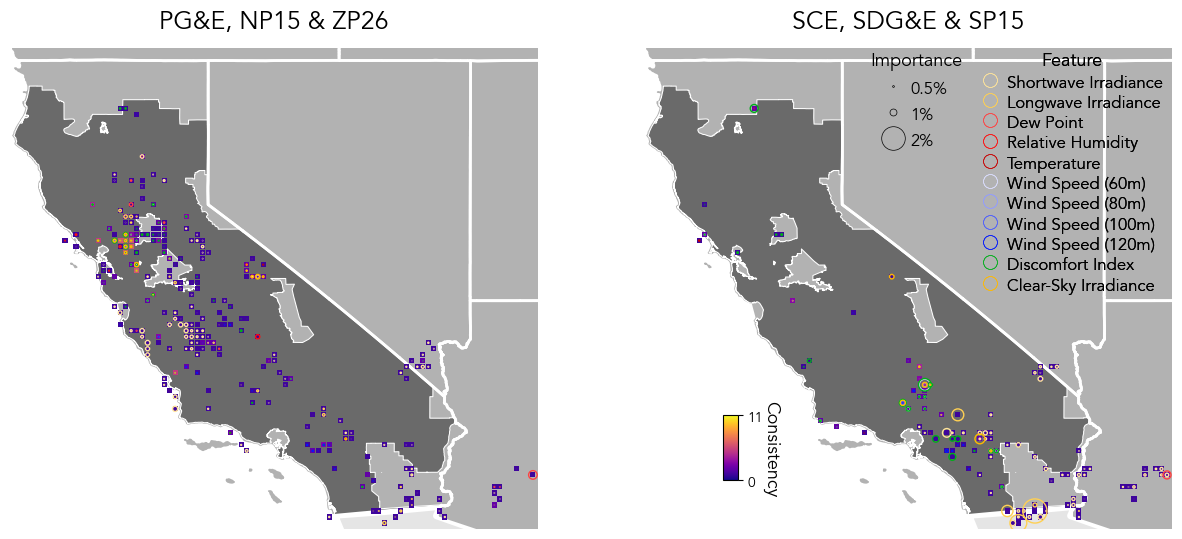

In [147]:
fig, (_ax1, _ax2) = plt.subplots(1, 2, figsize = (15, 6.5), squeeze = True)

# Loading spatial masks
M_ = _load_spatial_masks([[0], [1], [2]][i_resource], path_to_aux)
print(M_[0].shape, M_[1].shape, M_[2].shape, M_[3].shape)
print(W_ref_.shape)

i_zone = 0

features_, consistency_map_, importance_map_ = _consistency_and_importance_maps([[_model_1,_model_3], [_model_2, _model_3]][i_zone],
                                                                                M_, i_zone, tau = 0.)


_plot_feature_map(_ax1, _world, _US, _CAISO, features_, consistency_map_, W_ref_, 
                  c_max    = features_.shape[1],
                  title    = 'PG&E, NP15 & ZP26',
                  beta     = .01,
                  legend   = False)

i_zone = 1

features_, consistency_map_, importance_map_ = _consistency_and_importance_maps([[_model_1,_model_3], [_model_2, _model_3]][i_zone],
                                                                                M_, i_zone, tau = 0.)


_plot_feature_map(_ax2, _world, _US, _CAISO, features_, consistency_map_, W_ref_, 
                  c_max    = features_.shape[1],
                  title    = 'SCE, SDG&E & SP15',
                  beta     = .01,
                  legend   = True)

plt.savefig(path_to_images + 'features_map_ms_ES.pdf', bbox_inches = 'tight',
                                                       dpi         = 300)
        
plt.show()

(9152,) (9152,) (9152,) (9152,)
(9152,) (16940, 3) 1540
(11, 1540, 3) (11, 1540)


/Users/Guille/opt/anaconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3505: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


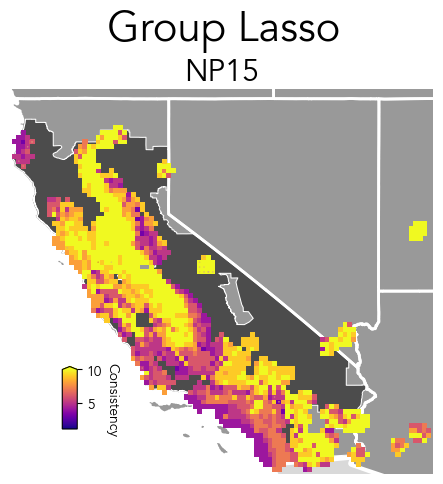

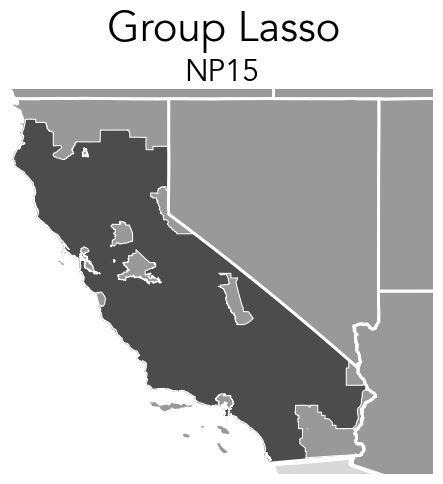

In [15]:
# Get Grid Dimensions
N = 104
M = 88

zones_ = ['NP15', 'SP15', 'ZP26']
i_zone = 0
zone   = zones_[i_zone]

# Loading spatial masks
M_ = _load_spatial_masks([[0, 1, 2], [0, 1, 2]][i_zone], path_to_aux)
print(M_[0].shape, M_[1].shape, M_[2].shape, M_[3].shape)

# NP15-Lasso-MTGPR-VS.pkl
# NP15-OMP-MTGPR-VS.pkl
# NP15-Elastic_Net-MTGPR-VS.pkl
# NP15-Group_Lasso-MTGPR-VS.pkl
label = 'Group_Lasso'
_model_1, meta_1_ = _load_model_data('NP15-Group_Lasso-MTGPR-LogS.pkl', path_to_mdls)
_model_2, meta_2_ = _load_model_data('SP15-Group_Lasso-MTGPR-LogS.pkl', path_to_mdls)
_model_3, meta_3_ = _load_model_data('ZP26-Lasso-MTGPR-ES.pkl', path_to_mdls)

features_, consistency_map_, importance_map_ = _consistency_and_importance_maps([_model_1, _model_2, _model_3][i_zone], M_, i_zone, tau = 0.)

# plt.figure()
# plt.imshow(consistency_map_.reshape(M, N)[::-1,])
# plt.colorbar()
# plt.show()

# plt.figure()
# plt.imshow(importance_map_.reshape(M, N)[::-1,])
# plt.colorbar()
# plt.show()
    
_plot_feature_map(_world, _US, _CAISO, 
                  features_, consistency_map_, W_ref_, i_zone,
                  c_max    = 10,
                  suptitle = r'  {}'.format(label.replace('_', ' ')),
                  title    = zone,
                  beta     = .01,
                  legend   = False, 
                  save     = True,
                  path     = path_to_images,
                  filename = 'features_map_{}_{}.png'.format(label, zone))


_plot_countour_feature_map(_world, _US, _CAISO, 
                           importance_map_, consistency_map_, W_ref_, i_zone,
                           suptitle = r'  {}'.format(label.replace('_', ' ')),
                           title    = zone,
                           beta     = .01,
                           legend   = False, 
                           save     = True,
                           c_max    = 10,
                           path     = path_to_images,
                           filename = 'features_map_{}_{}_v2.png'.format(label, zone))

(9152,) (16940, 3) 1540
(11, 1540, 3) (11, 1540)


/Users/Guille/opt/anaconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3505: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


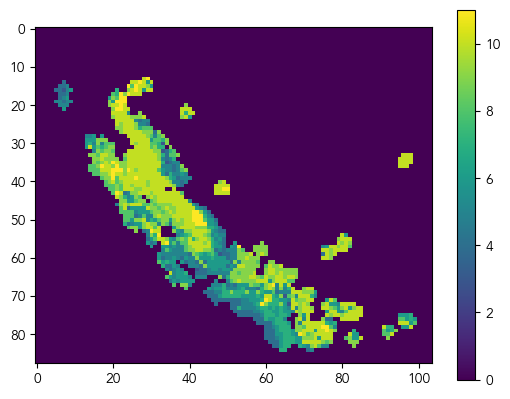

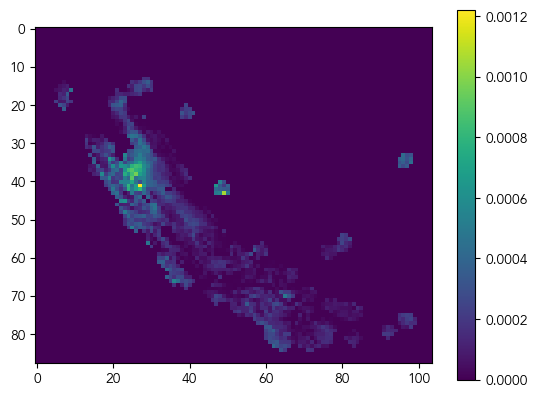

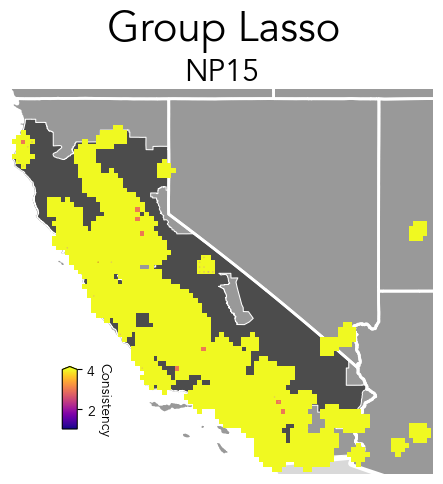

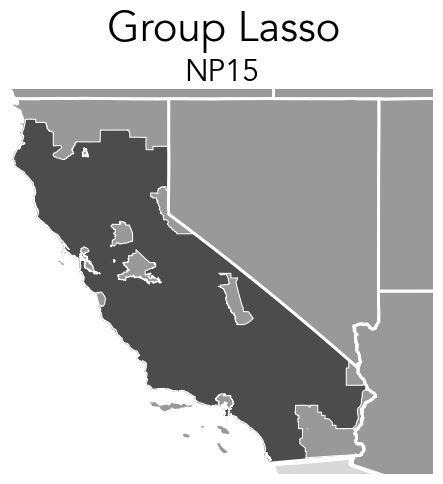

In [14]:
# NP15-Lasso-MTGPR-VS.pkl
# NP15-OMP-MTGPR-VS.pkl
# NP15-Elastic_Net-MTGPR-VS.pkl
# NP15-Group_Lasso-MTGPR-VS.pkl
label = 'Group Lasso'
_model_1, meta_1_ = _load_model_data('NP15-Group_Lasso-MTGPR-LogS.pkl', path_to_mdls)
_model_2, meta_2_ = _load_model_data('SP15-Group_Lasso-MTGPR-LogS.pkl', path_to_mdls)
_model_3, meta_3_ = _load_model_data('ZP26-Lasso-MTGPR-ES.pkl', path_to_mdls)

features_, consistency_map_, importance_map_ = _consistency_and_importance_maps([_model_1, _model_2, _model_3][i_zone], M_, i_zone, tau = 0.)

plt.figure()
plt.imshow(consistency_map_.reshape(M, N)[::-1,])
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(importance_map_.reshape(M, N)[::-1,])
plt.colorbar()
plt.show()
    
_plot_feature_map(_world, _US, _CAISO, 
                  features_, consistency_map_, W_ref_, i_zone,
                  c_max    = 4,
                  suptitle = r'  {}'.format(label),
                  title    = zone,
                  beta     = .01,
                  legend   = False, 
                  save     = True,
                  path     = path_to_images,
                  filename = 'features_map_{}_{}.pdf'.format(label, zone))


_plot_countour_feature_map(_world, _US, _CAISO, 
                           importance_map_, consistency_map_, W_ref_, i_zone,
                           suptitle = r'  {}'.format(label),
                           title    = zone,
                           beta     = .01,
                           legend   = False, 
                           save     = True,
                           c_max    = 4,
                           path     = path_to_images,
                           filename = 'features_map_{}_{}_v2.pdf'.format(label, zone))

# Population Density, Solar and Wind Power Plants Location Plot

In [3]:
tau = 750.

# Compose saving name
z_ref_ = pickle.load(open(path_to_aux + 'population_density_grid_0.125_(-125,-112)_(32,43).pkl', 'rb'))
pps_   = pd.read_csv(path_to_data + r'California_Power_Plants.csv').to_numpy()
data_  = pps_[pps_[:, 18] == 0, :]

data_p_ = data_[:, [0, 1, 18, 29, 31]]
W_, S_  = [], []
for i in range(data_p_.shape[0]):
    resource = data_p_[i, -1]
    if resource == 'SUN':
        S_.append(data_p_[i, [0, 1, 3]][np.newaxis, :])
    if resource == 'WND':
        W_.append(data_p_[i, [0, 1, 3]][np.newaxis, :])
        
S_ = np.concatenate(S_, axis = 0).astype(float)
W_ = np.concatenate(W_, axis = 0).astype(float)
print(S_.shape, W_.shape)
print(_CAISO)
idx_p_ = z_ref_ > tau
idx_   = []
# Loop over Grid coordinates
for i in range(W_ref_[idx_p_, :].shape[0]):
    if _CAISO.contains(Point([W_ref_[idx_p_, 0][i], W_ref_[idx_p_, 1][i]])).any():
        idx_.append(i)
        
P_ = np.concatenate((W_ref_[idx_p_, :], z_ref_[idx_p_][:, np.newaxis]), axis = 1)
P_ = P_[idx_, :]
print(P_.shape, len(idx_))

(777, 3) (118, 3)
     NAME  Id                                           geometry
1  CALISO   0  MULTIPOLYGON (((-115.03005 33.42860, -115.0142...
7  CALISO   0  POLYGON ((-122.99596 40.41839, -122.99820 40.4...
(82, 3) 82


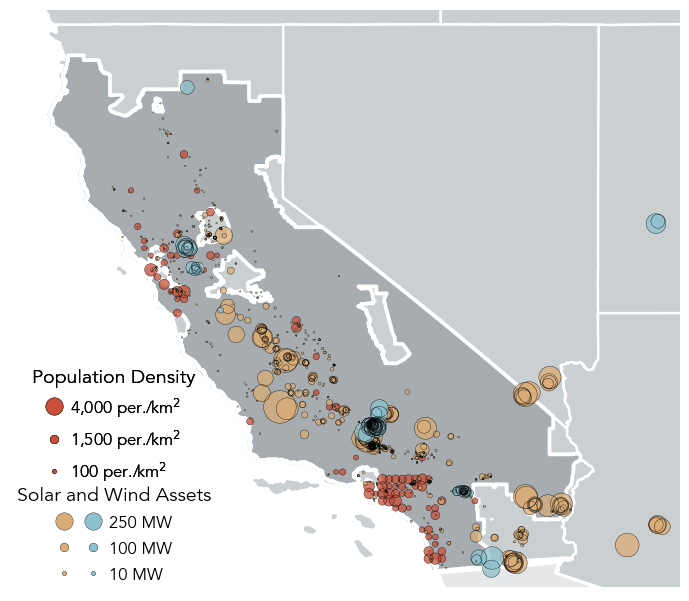

In [6]:
def _plot_assets_map(_world, _US, _CAISO, S_, W_, P_, W_ref_, legend, save, path = '', filename = 'unnamed.pdf'):


    x_0 = -124.5
    x_1 = -112.5
    y_0 = 32.25
    y_1 = 42.25

    x_ = [-124, -122, -120, -118, -116, -114]
    y_ = [34, 36, 38, 40, 42]


    fig, ax = plt.subplots(1, 1, figsize = (10, 7.5), 
                                 squeeze = True)

    ax = plt.subplot(1, 1, 1) 

    # ax.set_title('Population and Supply Assets', fontsize   = 36, 
    #                                              y          = 1.0625,
    #                                              fontweight = "bold")

    # plt.suptitle('CAISO', fontsize   = 30, 
    #                       fontweight = "bold")
    
    ax.scatter(S_[:, 0], S_[:, 1], s         = S_[:, 2]/1., 
                                   facecolor = '#daac77', 
                                   edgecolor = 'None',
                                   alpha     = 0.75, 
                                   zorder    = 5)

    ax.scatter(W_[:, 0], W_[:, 1], s         = W_[:, 2]/1.,
                                   facecolor = '#8dc0cd', 
                                   edgecolor = 'None',
                                   alpha     = 0.75, 
                                   zorder    = 6)

    ax.scatter(P_[:, 0], P_[:, 1], facecolor = '#c94f39', 
                                   edgecolor = 'None',
                                   s         = P_[:, 2]/60.,
                                   alpha     = 0.75, 
                                   zorder    = 4)

    ax.scatter(S_[:, 0], S_[:, 1], s         = S_[:, 2]/1.,
                                   facecolor = 'None',
                                   edgecolor = 'k',
                                   lw        = 0.25,
                                   alpha     = 1., 
                                   zorder    = 5)
    
    ax.scatter(W_[:, 0], W_[:, 1], s         = W_[:, 2]/1.,
                                   facecolor = 'None',
                                   edgecolor = 'k',
                                   lw        = 0.25,
                                   alpha     = 1., 
                                   zorder    = 6)

    ax.scatter(P_[:, 0], P_[:, 1], s         = P_[:, 2]/60.,
                                   facecolor = 'None',
                                   edgecolor = 'k',
                                   lw        = 0.25,
                                   alpha     = 1., 
                                   zorder    = 4)
        
    _US.to_crs("EPSG:4326").plot(ax        = ax, 
                                 linewidth = 1.75, 
                                 edgecolor = 'w', 
                                 facecolor = 'k',
                                 color     = '#CACFD2', 
                                 zorder    = 2)

    _CAISO.to_crs("EPSG:4326").plot(ax        = ax, 
                                    linewidth = 2.75, 
                                    edgecolor = 'w', 
                                    facecolor = 'k', 
                                    color     = '#A6ACAF', 
                                    alpha     = 1., 
                                    zorder    = 3)

    _world[_world['name'] == 'Mexico'].to_crs("EPSG:4326").plot(ax        = ax, 
                                                                linewidth = 5., 
                                                                edgecolor = 'w', 
                                                                facecolor = 'k',
                                                                color     = '#E5E7E9', 
                                                                alpha     = 1., 
                                                                zorder    = 1)

    if legend:
        legend_0_ = []
        for gen_capacity, gel_label in zip([12.5, 6.25, 3.125, 12.5, 6.25, 3.125], [1, 1, 1, 250, 100, 10]):
            if gel_label == 1:
                legend_0_.append(Line2D([0], [0], marker          = 'o', 
                                                  markersize      = gen_capacity, 
                                                  markeredgecolor = 'k',
                                                  markeredgewidth = .25,
                                                  color           = "None",
                                                  label           = '',
                                                  markerfacecolor = "#daac77")) 
            else:
                legend_0_.append(Line2D([0], [0], marker          = 'o', 
                                                  markersize      = gen_capacity, 
                                                  markeredgecolor = 'k',
                                                  markeredgewidth = .25,
                                                  color           = "None",
                                                  label           = '{:,} MW'.format(gel_label),
                                                  markerfacecolor = "#8dc0cd"))

        _leg_0 = ax.legend(handles        = legend_0_, 
                           title          = r'Solar and Wind Assets', 
                           loc            = 'upper right', 
                           ncol           = 2, 
                           bbox_to_anchor = (.285, .2),
                           columnspacing  = .225, 
                           handletextpad  = .5, 
                           handlelength   = 1.,
                           frameon        = False, 
                           fontsize       = 12, 
                           title_fontsize = 14)

        ax.add_artist(_leg_0)

        legend_1_ = []
        for pop_density, pop_label in zip([12.5, 6.25, 3.125], [4000, 1500, 100]):
            legend_1_.append(Line2D([0], [0], marker          = 'o', 
                                              markersize      = pop_density, 
                                              markeredgecolor = 'k',
                                              color           = "None",
                                              markeredgewidth = .25,
                                              label           = r'{:,} per./km$^2$'.format(pop_label),
                                              markerfacecolor = "#c94f39"))

        _leg_1 = ax.legend(handles        = legend_1_, 
                           title          = r'Population Density', 
                           loc            = 'upper right', 
                           ncol           = 1, 
                           bbox_to_anchor = (.26, .405),
                           columnspacing  = .225, 
                           handletextpad  = .5, 
                           handlelength   = 1.,
                           frameon        = False, 
                           fontsize       = 12, 
                           title_fontsize = 14)

        ax.add_artist(_leg_1)

    ax.set_xlabel('Longitude', fontsize = 14)
    ax.set_ylabel('Latitude', fontsize = 14)

    ax.set_xlim(x_0, x_1)
    ax.set_ylim(y_0, y_1)


    ax.axis('off')

    if save:
        plt.savefig(path + filename, bbox_inches = 'tight',
                                     dpi         = 250)
    plt.show()
    

_plot_assets_map(_world, _US, _CAISO, S_, W_, P_, W_ref_, 
                 path     = path_to_images, 
                 filename = 'CAISO_map.svg', 
                 save     = True, 
                 legend   = True)